<a href="https://colab.research.google.com/github/ksydata/DB_FEC_CreditScoringSystem/blob/main/%5BHCD_PAST_NCB%5D_DataAnalysis_ValuationMetric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 데이터 처리, 행렬, 배열과 선형대수학, 결측값 시각화, 시계열 데이터 모듈
import pandas as pd
import numpy as np
from collections import Counter
from numpy.linalg import eig
import missingno as msno
import datetime
from dataclasses import dataclass
from typing import *
from sklearn.preprocessing import RobustScaler

# 데이터 시각화 모듈
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import plotly.express as px

# 코랩 환경에 구글 드라이브를 마운트하는 모듈
from google.colab import drive
drive.mount('/content/drive')

# 주성분분석(PCA) 모듈 : 특징선택 또는 특징추출
from sklearn.decomposition import PCA
from sklearn.feature_selection import *

# 특징 공학(feature engineering) : 척도 변환
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 결측값 보간 모듈
from sklearn.impute import KNNImputer

from scipy.interpolate import interp1d
!pip install miceforest
import miceforest as mf

# 이상치 탐지 모듈
from sklearn.ensemble import IsolationForest

# 혼동행렬 등 분류모델 성능평가 모듈
from sklearn.metrics import *

# K-폴드 교차검증(K = 5, 10 일반적), 데이터 셋 분할, 하이퍼파라미터 격자탐색(grid search) 모듈
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# 결측값을 대체할 모델의 하이퍼파라미터(매개변수)를 최적화하는 목적으로 활용한 모듈
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Python에서 R호출하는 모듈
from rpy2.robjects import r
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# 클래스 불균형 모듈
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

# ML 분류기 모듈
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

# 통계적 가설검정 모듈
from scipy.stats import *
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import logit
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import RidgeClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1. 현재 및 과거 금융활동에 대한 원본 데이터 처리 및 병합

https://docs.python.org/ko/3/tutorial/classes.html#tut-object

`__init__`
`__next__`
`__dict__`
`__str__`
`__repr__`
`__class__`
`__call__`
`__eq__`
for문의 container의 iter()

In [ ]:
class HandlingData():
  # ImportData(), Astype(), New_Retaining()
  # [하나의 클래스로 여러 객체를 생성하여 코드의 반복을 줄임]
  # [클래스 하나만 변경하므로 모든 객체에 영향을 줄 수 있음]
  # [super(자식클래스, self).__init__(부모클래스 생성자 매개변수)]


  def __init__(self, current_path = None, past_path = None, colname = None, df = None) :
    self.current_path = current_path
    self.past_path = past_path
    self.colname = colname
    self.df = df


  def ImportData(self, current_path, past_path) :

    HCD = pd.read_csv(current_path, index_col = False)
    Past = pd.read_csv(past_path, index_col = False)
    HCD = pd.DataFrame(HCD)
    Past = pd.DataFrame(Past)

    # HCD(current application)
    HCD.drop(HCD.filter(like = "FLAG_DOCUMENT"), axis = 1, inplace = True)
    HCD.drop(HCD.filter(like = "EXT_SOURCE"), axis = 1, inplace = True)

    Column: List = []
    Column.extend(list(range(0, 19, 1)))
    Column.extend([21, 28, 31, 40, 84])
    Column.extend(list(range(88, 92, 1)))
    HCD = HCD.iloc[:, Column]

    # Past(previous application of home credit loan)
    Past.groupby(["AMT_DOWN_PAYMENT"]).size()
    Index = Past[Past["AMT_DOWN_PAYMENT"] != 0].index.tolist()
    Past.drop(Index, axis = 0, inplace = True)
    Past["AMT_DOWN_PAYMENT"].unique()
		  # [대출목적이 XAP가 아닌 신용대출의 계약금은 모두 0이므로 Down payment > 0인 행 모두 제거]

    Past = Past.drop(
        Past.columns[[6, 8, 9, 10, 11, 12, 17, 20, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35]], axis = 1)

    # New Credit Bureau : 데이터프레임 병합
    NCB = pd.merge(left = HCD, right = Past, how = "left", on = "SK_ID_CURR")
    NCB = pd.DataFrame(NCB)
    NCB.sort_values(by = ["SK_ID_CURR"], ascending = True)
    NCB["duplicate"] = NCB.duplicated(["SK_ID_CURR"])
    # NCB[NCB["duplicate"] == True]

    return NCB


  def Astype(self, df: pd.DataFrame, colname: List):

    for col in colname:
      df[col] = df[col].astype("category")
    return df


  def New_RetainingClient(self, df: pd.DataFrame) :
      # [df = NCB]
      # [NCB에서 해당 기관의 과거 대출 이력이 없는 신규 고객 분리 후 새로운 데이터 프레임 생성]
    NCB_NA_column = df.iloc[:, [28, 29, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42]].columns.tolist()

    for i in range(1, 12, 1) :
      globals()["is_NaN_{}".format(i)] = df[NCB_NA_column[i]].isnull()
        # [과거 여신금융활동 이력이 없는 신규 고객을 True, 아니면 False로 is_NA]
        # [Past 변수가 결측인 행을 확인]
      NCB_new = df[globals()["is_NaN_{}".format(i)]]

    NCB_new_index = NCB_new.index.tolist()
      # [NCB_new 신규고객의 행 번호를 list 형태로 NCB_new_index에 저장함]
    NCB_new.drop(["OWN_CAR_AGE", "RATE_INTEREST_PRIMARY", "RATE_INTEREST_PRIVILEGED"], axis = 1, inplace = True)
    df.drop(NCB_new_index, axis = 0, inplace = True)
    df.drop(["OWN_CAR_AGE", "RATE_INTEREST_PRIMARY", "RATE_INTEREST_PRIVILEGED"], axis = 1, inplace = True)

    return NCB_new, df

In [ ]:
handlingData = HandlingData()

In [ ]:
NCB = handlingData.ImportData(
    current_path = "/content/drive/MyDrive/application_train.csv",
    past_path = "/content/drive/MyDrive/previous_application.csv"
)

In [ ]:
NCB = handlingData.Astype(
    df = NCB,
    colname = [
        "TARGET", "NAME_CONTRACT_TYPE_x", "CODE_GENDER",
        "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
        "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",  "NAME_HOUSING_TYPE",
        "OCCUPATION_TYPE", "REGION_RATING_CLIENT_W_CITY", "ORGANIZATION_TYPE", "HOUSETYPE_MODE",
        "NAME_CONTRACT_TYPE_y", "NAME_CASH_LOAN_PURPOSE", "NAME_CONTRACT_STATUS", "NAME_PAYMENT_TYPE",
        "CODE_REJECT_REASON", "NAME_CLIENT_TYPE", "NAME_GOODS_CATEGORY", "NAME_SELLER_INDUSTRY", "NAME_YIELD_GROUP",
        "PRODUCT_COMBINATION", "NFLAG_INSURED_ON_APPROVAL",
        "duplicate"])

  # [TypeError: Astype() got multiple values for argument 'colname']
  # [TypeError: Astype() takes 1 positional argument but 2 were given]
  # [UnboundLocalError: local variable 'NCB' referenced before assignment]
  # [UnboundLocalError: local variable 'NCB' referenced before assignment]
  # [AttributeError: 'DataFrame' object has no attribute 'col']

In [ ]:
NCB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442562 entries, 0 to 442561
Data columns (total 47 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR                   442562 non-null  int64   
 1   TARGET                       442562 non-null  category
 2   NAME_CONTRACT_TYPE_x         442562 non-null  category
 3   CODE_GENDER                  442562 non-null  category
 4   FLAG_OWN_CAR                 442562 non-null  category
 5   FLAG_OWN_REALTY              442562 non-null  category
 6   CNT_CHILDREN                 442562 non-null  int64   
 7   AMT_INCOME_TOTAL             442562 non-null  float64 
 8   AMT_CREDIT_x                 442562 non-null  float64 
 9   AMT_ANNUITY_x                442548 non-null  float64 
 10  AMT_GOODS_PRICE_x            442153 non-null  float64 
 11  NAME_TYPE_SUITE              440939 non-null  category
 12  NAME_INCOME_TYPE             442562 non-null

In [ ]:
NCB_new, NCB = handlingData.New_RetainingClient(df = NCB)
  # [SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame]

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
print(NCB_new.shape, NCB.shape)

(128587, 44) (313975, 44)


### 2. MICE(연쇄방정식 기반 랜덤 포레스트 모델을 이용한 결측값 다중대체법) with Python, R

> https://github.com/AnotherSamWilson/miceforest

In [ ]:
class MissingDataImputation:
  def __init__(self, df = None):
    self.df = df

# mice_randomForest()
# 랜덤포레스트 기반의 다중대체법으로 결측값을 채우는 함수

  def mice_randomForest(self, df: pd.DataFrame):

    column_location: List = []
    for column in df.select_dtypes(include = "category").columns.tolist():
      column_location.append(df.columns.get_loc(column))
      # [범주형 변수의 열번호 리스트 생성]

    mice_rf = mf.ImputationKernel(df,
                                  datasets = 5,
                                  save_all_iterations = True,
                                  categorical_feature = column_location,
                                  random_state = 2023)
      # [datasets] 결측값이 다른 관측값으로 대체된 데이터 샛 5개 생성
      # [categorical_feature] auto
    mice_rf.mice(iterations = 2)
      # [iterations] 각 데이터셋을 2번 반복하여 생성
    NCB_MICE = mice_rf.complete_data()

    return NCB_MICE
      # [결측값이 대체된 완전한 데이터 반환]

In [ ]:
MICE = MissingDataImputation()

In [ ]:
NCB_MICE = MICE.mice_randomForest(df = NCB)
  # [AssertionError: NAME_INCOME_TYPE has unused categories: Businessman]
  # [ValueError: If categories are already encoded as such, set categorical_feature = auto]

```
# MICE with R

library(readr)
library(ggplot2)
library(VIM)
library(mice)
library(missForest)

NCB <- read.csv("NCB.csv", header = TRUE, sep = ",", na.strings = "NA")

for (i in c(1:44)) {
  NCB[, i] <- ifelse(NCB[, i] == "", NA, NCB[, i])
}
for (i in c(1:44)) {
  if (class(NCB[, i]) == "character") {
    NCB[, i] <- as.factor(NCB[, i])
  }
}
str(NCB)
NCB$TARGET <- NULL
NCB$AMT_CREDIT_x <- NULL
NCB$AMT_CREDIT_y <- NULL
NCB$SK_ID_CURR <- NULL
NCB$SK_ID_PREV <- NULL

NCB$DAYS_BIRTH <- abs(NCB$DAYS_BIRTH)
NCB$DAYS_EMPLOYED <- ifelse(NCB$DAYS_EMPLOYED > 0, 0, NCB$DAYS_EMPLOYED)
NCB$DAYS_EMPLOYED <- abs(NCB$DAYS_EMPLOYED)

MICE_1_PLOT <- aggr(NCB, col = c("black", "blue"), cex.axis = 0.3, cex.lab = 0.7)
```

```
# Fit MICE with Random Forest

MICE <- mice(NCB, method = "rf", m = 1)
MICE_df <- complete(MICE, 1)
write.csv(MICE_df, "NCB_MICE.csv")

MICE_PLOT <- aggr(MICE_df, col = c("black", "grey"), cex.axis = 0.3, cex.lab = 0.7)

table(is.na(MICE_df))
table(is.na(NCB))

MICE$nmis
  # AMT_GOODS_PRICE_x
  # NAME_TYPE_SUITE
  # OCCUPATION_TYPE
  # HOUSETYPE_MODE
  # OBS_30_CNT_SOCIAL_CIRCLE
  # DEF_30_CNT_SOCIAL_CIRCLE
  # OBS_60_CNT_SOCIAL_CIRCLE
  # DEF_60_CNT_SOCIAL_CIRCLE
  # AMT_ANNUITY_y
  # NFLAG_INSURED_ON_APPROVAL
```

### 3. 주성분분석(Principal Component Aalysis) 연속형 변수 특징 선택

> 여러 데이터들이 모여 하나의 분포를 이룰 때 이 분포의 주 성분(그 방향으로 데이터들의 분산이 가장 큰 방향벡터)을 분석해 주는 방법이다.

In [ ]:
class FeatureSelection_PCA:
  def __init__(self, path = None, df = None, n = None):
     self.path = path
     self.df = df
     self.n = n


  # 1. Data frame with Numeric Features
    # [PCA를 하기 위한 전처리 : 연속형 변수만 추출한 데이터 프레임 생성]
    # [출력값 : pca_coliumn ; 연속형 변수만 추출한 데이터 프레임]

  def ImportData(self, path):
    NCB_MICE = pd.read_csv(path, index_col = False)

    return NCB_MICE


  def numeric_list_forPCA(self, df: pd.DataFrame):

    pca_column_list = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    pca_column = df.loc[:, pca_column_list]
      # [연속형 변수들만 담긴 pca_col 데이터 프레임 생성]

    pca_column = pd.DataFrame(data = StandardScaler().fit_transform(pca_column),
                              columns = pca_column_list)
      # [표준화 : 측정단위가 다른 각 컬럼의 변동성을 비교하기 위한 척도 변환]

    return pca_column


  # 2. PCA, Screeplot : 최적 components 찾기
    # [출력값 : pca_nrate ; 누적 기여율 데이터 프레임]
    """
    pca_array = pca.fit_transform(df)
        pca_nrate = pd.DataFrame(pca_array, columns = [f"pca{num+1}" for num in range(0,n,1)])
        return pca_nrate
    """

  def OptimalPCA(self, df: pd.DataFrame, n: int):

    pca_object = PCA(n_components = n)
        # [ScreePlot 그릴 때 : n = 17 (len(pca_col_list))]
        # [PCA 돌릴 때 : n = 9]
    pca_dataframe = pd.DataFrame(data = pca_object.fit_transform(df),
                                 columns = [f"pca{num + 1}" for num in range(0, n, 1)])
    pca_component = pca_object.components_
    pca_variance = pca_object.explained_variance_ratio_

    return pca_dataframe, pca_component, pca_variance
      # [주성분(PC)과 고윳값(var)]


  # PCA 객체의 속성에 저장된 구성요소(원본 데이터 pca_column의 변수 조합)을 해석하는 히트맵
  def PCAHeatMap(self, df: pd.DataFrame, n: int):

    dataframe, principal_component, variance_ratio = FeatureSelection_PCA().OptimalPCA(df = df, n = n)
    # self.OptimalPCA(df = df, n = n)
      # [OptimalPCA 함수 불러오기]

    map = pd.DataFrame(principal_component,
                       columns = df.columns)
      # [ValueError: Shape of passed values is (9, 18), indices imply (9, 9)]

    plt.figure(figsize = (12, 8))
    sns.heatmap(map, cmap = "Spectral")
      # [상관계수 시각화하는 히트맵]


  def ScreePlot(self, df: pd.DataFrame, n: int):

    dataframe, principal_component, variance_ratio = FeatureSelection_PCA().OptimalPCA(df = df, n = n)
        # [OptimalPCA 함수 불러오기]

    plt.rcParams["figure.figsize"] = (7, 7)
    plt.bar(range(1, dataframe.shape[1] + 1), variance_ratio, color = "blue")
    plt.plot(range(1, dataframe.shape[1] + 1), variance_ratio.cumsum(), color = "orange", marker = "o")
        # [shape[1] : 데이터프레임 열의 수]

    plt.xlabel("number of Principal Components", fontsize = 12)
    plt.ylabel("% of Variance Explained", fontsize = 12)
    plt.show()


  def biplot(self, df: pd.DataFrame, n: int, labels):

    dataframe, principal_component, variance_ratio = FeatureSelection_PCA().OptimalPCA(df = df, n = n)

    PC1 = dataframe.iloc[:, 0]
    PC2 = dataframe.iloc[:, 1]

    coefficient = np.transpose(principal_component[0:2, :])
    num = coefficient.shape[0]
      # [주성분 1, 2]

    scalePC1 = 1.0 / (PC1.max() - PC1.min())
    scalePC2 = 1.0 / (PC2.max() - PC2.min())
      # [최소최대 정규화]
    plt.scatter(PC1 * scalePC1, PC2 * scalePC2)

    # plt.scatter(PC1, PC2)

    for i in range(num):
      plt.arrow(0, 0,
                coefficient[i, 0], coefficient[i, 1],
                color = "r", alpha = 0.5)
        # [원본 특성변수의 분산을 나타내는 직선] loadings(coef, eigen value)

      if labels is None:
        plt.text(coefficient[i, 0] * 1.15,
                 coefficient[i, 1] * 1.15,
                 "Feature" + str(i + 1),
                 color = "g",
                 fontsize = 8,
                 ha = "center",
                 va = "center")
          # [라벨의 위치 설정]
      else:
        plt.text(coefficient[i, 0] * 1.15,
                 coefficient[i, 1] * 1.15,
                 labels[i],
                 color = "g",
                 fontsize = 8,
                 ha = "center",
                 va = "center")

    plt.xlim(-0.5, 1)
    plt.ylim(-0.5, 1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

In [ ]:
featureSelection = FeatureSelection_PCA()

In [ ]:
NCB_MICE = featureSelection.ImportData("/content/drive/MyDrive/NCB_MICE_5.csv")
# NCB_MICE = featureSelection.Import("/content/drive/MyDrive/NewImpact/데이터/NCB_MICE_5.csv")
NCB_MICE.drop("Unnamed: 0", axis = 1, inplace = True)

In [ ]:
pca_column = featureSelection.numeric_list_forPCA(df = NCB_MICE)

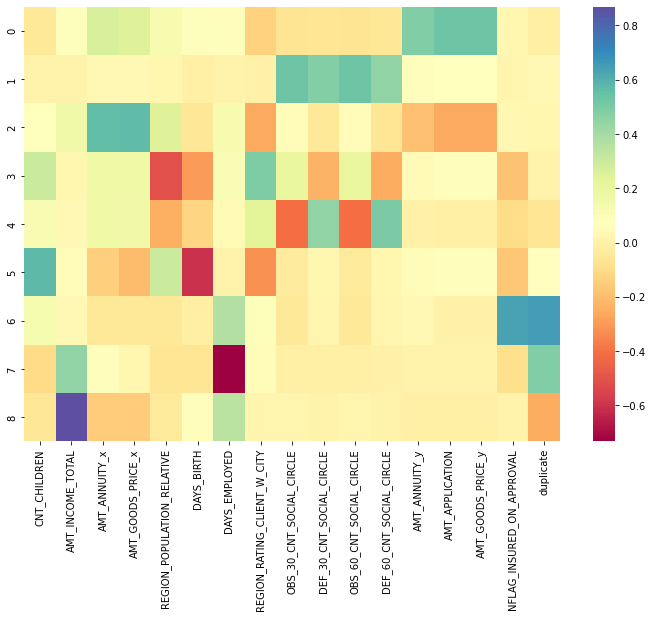

In [ ]:
featureSelection.PCAHeatMap(df = pca_column, n = 9)

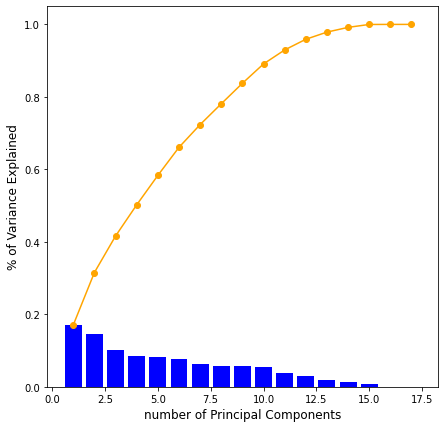

In [ ]:
featureSelection.ScreePlot(df = pca_column, n = 17)

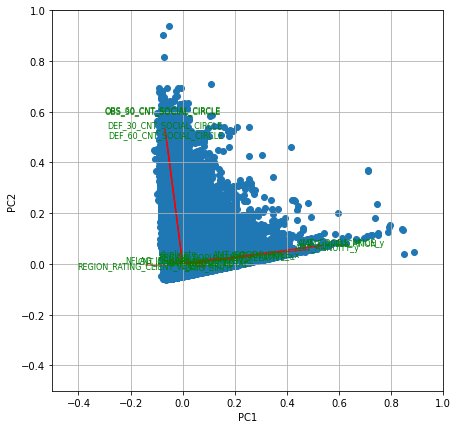

In [ ]:
featureSelection.biplot(df = pca_column,
                        n = 2,
                        labels = pca_column.columns.values)

In [ ]:
pca_numeric = ["OBS_80_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCAIL_CIRCLE", "AMT_ANNUITY_y", "AMT_APPLICATION", "AMT_GOOD_PRICES_y"]

### 4. 연속형, 범주형 특징선택을 위한 필터링

In [ ]:
class FeatureSelection_Filtering():
  def __init__(self, df = None, x1 = None, y1 = None, x2 = None, y2 = None,
               selected_numeric_list = None, selected_numeric2_list = None,
               selected_numfac_list = None, selected_numfac2_list = None,
               totalSelectedNumeric = None):
    self.df = df
    self.x1 = x1
    self.y1 = y1
    self.x2 = x2
    self.y2 = y2
    self.selected_numeric_list = selected_numeric_list
    self.selected_numeric2_list = selected_numeric2_list
    self.selected_numfac_list = selected_numfac_list
    self.selected_numfac2_list = selected_numfac2_list
    self.totalSelectedNumeric = totalSelectedNumeric

  # 결측값 대체 시 일시적으로 제거했던 ID 변수 및 종속변수 불러오기
  def ImportData(self, df_DV: pd.DataFrame, df_IV: pd.DataFrame):

    NCB_DV = df_DV.loc[:,
                       ["TARGET", "AMT_CREDIT_x", "AMT_CREDIT_y", "SK_ID_CURR", "SK_ID_PREV"]]
    NCB_DV = NCB_DV.reset_index()
      # [기존 NCB 행 번호 오름차순 정렬]
    NCB_DV.drop("index", axis = 1, inplace = True)
      # [기존 NCB의 0 ~ 442,562행 번호 제거하여 0 ~ 313974로 대체]

    NCB_MICE_join = pd.concat([NCB_DV, df_IV], axis = 1, ignore_index = False)
    for column in NCB_MICE_join.select_dtypes(include = "object").columns.tolist():
      NCB_MICE_join[column] = NCB_MICE_join[column].astype("category")

    NCB_MICE_join["TARGET"] = NCB_MICE_join["TARGET"].astype("int")

    NCB_MICE_join = pd.get_dummies(NCB_MICE_join)

    NCB_MICE_join["TARGET"] = NCB_MICE_join["TARGET"].astype("category")
    self.df = NCB_MICE_join
    return NCB_MICE_join

  # F-통계량 및 상호정보량 기반 필터링 (연속형 특징선택 목적)

  def filtering_preprocessing(self):
        # [df = NCB_MICE_join]
        # [x는 독립변수, y는 종속변수]

    self.x1 = self.df.select_dtypes(include = ["category", "object"])
        # [x1 : 범주형 변수]
    self.x2 = self.df.select_dtypes(include = ["int", "float"])
        # [x2 : 연속형 변수]
    self.x2.drop(["SK_ID_CURR", "SK_ID_PREV", "AMT_CREDIT_y"], axis = 1, inplace = True)

    self.y1 = self.x1["TARGET"]
        # [y1 : 이진 범주형 종속변수]
    self.y2 = self.x2["AMT_CREDIT_x"]
        # [y2 : 연속형 종속변수]

    self.x1 = self.x1.drop("TARGET", axis = 1)
    self.x2 = self.x2.drop("AMT_CREDIT_x", axis = 1)

    st_scaler = RobustScaler()
        # [변형 객체 저장] 평균과 분산 대신에 중간 값과 사분위 값을 사용하여 이상치 영향 최소화
        # 모든 스케일러 처리 전 이상치 제거가 선행되어야 하지만 차원의 저주를 먼저 해결한 후 이상치 탐지 및 판정 후 처리기준 수립할 계획
    self.x1 = pd.DataFrame(self.x1, columns = self.x1.columns.values)
    self.x2 = pd.DataFrame(st_scaler.fit_transform(self.x2), columns = self.x2.columns.values)


  # 1) y2 = 연속형 변수(AMT_CREDIT(대출금액)), x2 = 연속형 변수
    # F-통계량이 높은 6개 연속형 변수(특징) 선택
  def numeric_numeric_filtering(self):
    f_num = SelectKBest(f_regression, k = 6)
    f_num.fit(self.x2, self.y2)
    selected_numeric = self.x2.columns[f_num.get_support()]
       # [인스턴스를 인덱스로 사용하여 선택된 6개 변수를 특징 목록 selected_numeric으로 저장]

    self.selected_numeric_list = []
    for i in range(0,6,1):
      self.selected_numeric_list.append(selected_numeric[i])

     # 상호 정보량이 높은 6개 연속형 변수(IV, 특징) 선택
    f_num2 = SelectKBest(mutual_info_regression, k = 6)
      # [X확률과 Y확률 중 두 사건 X, Y가 동시에 일어날 확률 측정]
      # MutualInformation(X, Y) = P(X∩Y) / P(X)*P(Y)
    f_num2.fit(self.x2, self.y2)
    selected_numeric2 = self.x2.columns[f_num2.get_support()]

    self.selected_numeric2_list = []
    for i in range(0, 6, 1):
      self.selected_numeric2_list.append(selected_numeric2[i])

    #return self.selected_numeric_list, self.selected_numeric2_list


  # 2) y1 = 범주형 변수(TARGET(개인/가계신용대출 상환 여부)), x2 = 연속형 변수
    # F-통계량이 높은 6개 연속형 변수(특징) 선택

  def factor_numeric_filtering(self):
    f_numfac = SelectKBest(f_classif, k = 6)
    f_numfac.fit(self.x2, self.y1)
    selected_numfac = self.x2.columns[f_numfac.get_support()]

    self.selected_numfac_list = []
    for i in range(0, 6, 1):
      self.selected_numfac_list.append(selected_numfac[i])

     # 상호정보량이 높은 6개 연속형 변수(IV, 특징) 선택
    f_numfac2 = SelectKBest(mutual_info_classif, k = 6)
    f_numfac2.fit(self.x2, self.y1)
    selected_numfac2 = self.x2.columns[f_numfac2.get_support()]

    self.selected_numfac2_list = []
    for i in range(0, 6, 1):
      self.selected_numfac2_list.append(selected_numfac2[i])

    # return self.selected_numfac_list, self.selected_numfac2_list


  # 3) pca_columns, selected_numric_list,2 selected_numfac,2 의 교집합 변수만 추출
  # totalNumericSelection

  def totalNumericSelection(self, pca_col):
    self.totalSelectedNumeric = [pca_col, self.selected_numeric_list, self.selected_numeric2_list, self.selected_numfac_list, self.selected_numfac2_list]

    # return self.totalSelectedNumeric
    intersection = []
    for alist in self.totalSelectedNumeric:
      for blist in self.totalSelectedNumeric:
        if alist == blist:
          pass
        else:
          intersection.append(np.intersect1d(alist, blist))
    #return intersection

    NumericSelection = set()
    for i in range(len(intersection)):
      for j in range(len(intersection[i])):
        NumericSelection.add(intersection[i][j])
    #return NumericSelection

    NumericSelection2 = {
        "AMT_ANNUITY_x", "AMT_GOODS_PRICE_x", "DAYS_EMPLOYED", "AMT_ANNUITY_y", "AMT_APPLICATION",
        "DAYS_BIRTH", "DAYS_EMPLOYED", "AMT_ANNUITY_y",
        "DAYS_EMPLOYED", "AMT_ANNUITY_y", "AMT_ANNUITY_x", "AMT_GOODS_PRICE_x", "DAYS_EMPLOYED", "AMT_GOODS_PRICE_y",
        "DAYS_BIRTH", "DAYS_EMPLOYED", "AMT_ANNUITY_x", "AMT_GOODS_PRICE_x", "DAYS_BIRTH", "DAYS_EMPLOYED"
        }
          # [MinMax Scaling(0~1 정규화) 후 연속형 변수 특징 선택]
    return np.intersect1d(list(NumericSelection), list(NumericSelection2))


  # 4) y1 = 범주형 변수, x1 = 범주형 변수
  # 카이제곱 독립성 검정

  def factor_factor_filtering(self):
    CategoricalDummy = self.df.select_dtypes(include = ["uint8"]).columns.tolist()

    chi_squared_test = []
    chi_squared_statistics = []

    for IV in CategoricalDummy:
      if chi2_contingency(pd.crosstab(self.df["TARGET"], self.df[IV]))[1] <= 0.05:
        # [NCB_MICE_join의 categorical IV와 DV(TARGET)의 교차표 작성]
        chi_squared_test.append("Reject Null Hypothesis")
            # [H0] 두 변수 간 독립 [Ha] 두 변수 상호 영향
            # [귀무가설(H0) 기각]
      else :
        # [카이제곱 독립성 검정 결과 p-value가 5% 이상일 경우]
        chi_squared_test.append("Accept Null Hypothesis")

      chi_squared_statistics.append(
        chi2_contingency(pd.crosstab(self.df["TARGET"], self.df[IV]))[0]
        )
          # [카이제곱 검정통계량을 리스트에 저장]

    chi2_statistics = pd.DataFrame(
        data = [CategoricalDummy, chi_squared_statistics]
        ).T
        # [범주형 독립변수명 리스트와 카이제곱 독립성 검정통계량 리스트의 행렬 변환]
    chi2_statistics.columns = ["Independent Variable", "Chisquared_statistics"]

    chi_result = chi2_statistics.sort_values(by = "Chisquared_statistics", axis = 0, ascending = False).head(20)

    CategorySelected = chi_result["Independent Variable"].unique().tolist()


    # 상호정보량이 높은 20개 변수 추출
    selected_fac_mi = SelectKBest(score_func = mutual_info_classif, k = 6)
    selected_fac_mi.fit(self.df.loc[:, CategoricalDummy], self.df["TARGET"])
    selected_fac = selected_fac_mi.transform(self.df.loc[:, CategoricalDummy])

    selected_fac_dict = dict(
        zip(CategoricalDummy, selected_fac_mi.scores_)
    )
        # [변수명 리스트와 상호정보량에 의한 범주형 특징선택 결과(selected_fac_mi.scores_) 리스트를 zip으로 압축하여 딕셔너리 타입 지정]
        # [selected_fac_dict[KEY] 변수명]
        # [selected_fac_dict[VALUES] 범주형 더미변수의 상호정보량]

    selected_fac_sorted = sorted(selected_fac_dict.items(), key = lambda x : x[1], reverse = True)[:20]
        # [selected_fac_dict를 내림차순 정렬하여 selected_fac_sorted에 저장]

    mutual_information_variable = []
    for i in selected_fac_sorted:
      mutual_information_variable.append(i[0])

    return [x for i in CategorySelected for x in mutual_information_variable if i in x]



In [ ]:
featureFiltering = FeatureSelection_Filtering()

In [ ]:
NCB_MICE_join = featureFiltering.ImportData(df_DV = NCB,
                                            df_IV = NCB_MICE)

In [ ]:
featureFiltering.filtering_preprocessing()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
featureFiltering.numeric_numeric_filtering()

In [ ]:
featureFiltering.factor_numeric_filtering()

In [ ]:
featureFiltering.totalNumericSelection(pca_col = pca_numeric)

array(['AMT_ANNUITY_x', 'AMT_ANNUITY_y', 'AMT_APPLICATION',
       'AMT_GOODS_PRICE_x', 'DAYS_BIRTH', 'DAYS_EMPLOYED'], dtype='<U17')

In [ ]:
featureFiltering.factor_factor_filtering()

['CODE_GENDER_M',
 'CODE_GENDER_F',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_CONTRACT_STATUS_Approved',
 'CODE_REJECT_REASON_XAP',
 'NAME_CONTRACT_TYPE_x_Cash loans',
 'NAME_HOUSING_TYPE_House / apartment']

### 5. 이상치 처리를 위한 격리 포레스트 모델 적합

> 객체 변수는 클래스로부터 생성된 **각각의 객체/인스턴스에 속하는 변수**이다.
이는 객체별로 변수를 가지며, **서로 공유되지 않고 각 인스턴스에 존재하는 것**으로 같은 이름의 필드끼리 서로 간섭되지 않는다.

> 코드를 테스트하는 방법에 대한 고민을 지속적으로 하여야 한다.

In [ ]:
# FeatureSelection 함수에서 NCB_MICE_FS 데이터를 완성하여 실행할 것

NCB_MICE_FS = pd.read_csv("/content/drive/MyDrive/NCB_MICE_NEW.csv")

In [ ]:
class OutlierDetection:
  def __init__(self, df = None):
    self.df = df

# isolationForestGridSearch()
# 최적의 이상치 탐지비율(contamination parameter) 그리드 서치하는 모델 최적화 후 적합하는 함수

  def isolationForestGridSearch(self, df: pd.DataFrame, num_col_list: List, optimal_ratio: float):

  # 1. 비지도학습이므로 y 없다는 가정 하에 데이터 셋 5:5 분할
    x_train_outlier, x_test_outlier = train_test_split(df.loc[:, num_col_list],
                                                       test_size = 0.5,
                                                       random_state = 2023)

    # 0.1%부터 0.5%까지 0.01% 단위로 이상치 탐지비율 리스트 생성
    ratio_contain: List = []
    ratio: float = 0.0009

    while ratio:
      if ratio < 0.005:
        ratio += 0.0001
        ratio = round(ratio, 5)
        ratio_contain.append(ratio)
      else:
        break


  # 2. 분할한 데이터를 활용하여 예측한 결과를 전역 변수로 생성
    np.random.seed(2023)
   # [contamination] 이상치 탐지비율별 모형 선언
    for r in ratio_contain:
      globals()["isolation_outlier_{}".format(r)] = IsolationForest(
          contamination = r,
          n_estimators = 50,
          max_samples = 1000,
          max_features = 1.0,
          bootstrap = False,
          n_jobs = None,
          random_state = 2023,
          verbose = 0
      )

      # 훈련용 데이터로 이상치 탐지모델을 학습시켜 isolation_outlier_fit에 저장
      globals()["isolation_outlier_fit_{}".format(r)] = globals()["isolation_outlier_{}".format(r)].fit(x_train_outlier)

      # 훈련용 데이터로 학습시킨 모델로 검증용 데이터의 이상치 예측한 결과 pred_test
      globals()["pred_test_{}".format(r)] = globals()["isolation_outlier_fit_{}".format(r)].predict(x_test_outlier)

      # 검증용 데이터로 이상치 탐지 모델을 학습시켜 isolation_outlier_fit_test에 저장
      globals()["isolation_outlier_fit_test_{}".format(r)] = globals()["isolation_outlier_{}".format(r)].fit(x_test_outlier)

      # 검증용 데이터로 학습시킨 모델로 검증용 데이터의 이상치 예측한 결과 refer_test
      globals()["refer_test_{}".format(r)] = globals()["isolation_outlier_fit_test_{}".format(r)].predict(x_test_outlier)


  # 3. 예측된 이상치와 실제 이상치를 비교하는 혼동행렬 작성 후 재현율(성능) 평가
    for r in ratio_contain:
      globals()["isolation_cf_{}".format(r)] = confusion_matrix(globals()["refer_test_{}".format(r)], globals()["pred_test_{}".format(r)])
        # [confusion_matrix]의 해석
        #   refer    pred
        #   TP [0,0] FN [0,1]
        #   FP [1,0] TN [1,1]
      globals()["Recall_{}".format(r)] = globals()["isolation_cf_{}".format(r)][0,0] / (globals()["isolation_cf_{}".format(r)][0,0] + globals()["isolation_cf_{}".format(r)][0, 1])

    # 격리 포레스트 모델 하이퍼파리미터에 따른 성능평가지표 데이터프레임 생성
    iForest_recall = pd.DataFrame(data = {"contamination_ratio":ratio_contain,
                                          "performance_measure":np.zeros(41)})
    index: int = 0
    for r in ratio_contain:
      iForest_recall.at[index, "performance_measure"] = globals()["Recall_{}".format(r)]
      index += 1

    # 최적의 이상치 탐지모델 적합
    isolation_outlier = IsolationForest(contamination = optimal_ratio,
                                        n_estimators = 50,
                                        max_samples = 1000,
                                        max_features = 1.0,
                                        bootstrap = False,
                                        n_jobs = None,
                                        random_state = 2023,
                                        verbose = 0)
      # [50개 노드 수] [최대 1000개 샘플] [0.0014%의 이상치 색출(오염 정도)]

    isolation_outlier.fit(x_train_outlier)
    pred_train = isolation_outlier.predict(x_train_outlier)
    pred_test = isolation_outlier.predict(x_test_outlier)

    x_train_outlier["IF_anomaly_score"] = pred_train
    x_test_outlier["IF_anomaly_score"] = pred_test
      # [이상치 점수(맞으면 -1, 아니면 1)를 변수로 생성]

    NCB_Isolation = pd.concat([x_train_outlier, x_test_outlier], axis = 0)
      # [훈련용 및 검증용 데이터를 행 기준으로 병합]
    NCB_Isolation.sort_index(inplace = True)
      # [행 번호 기준 정렬]

    outlier_index = NCB_Isolation[NCB_Isolation["IF_anomaly_score"] == -1].index.tolist()
      # [이상치로 탐지된 데이터의 행 번호 outlier_index 리스트에 저장]
    NCB_MICE_FS_OD = NCB_MICE_FS.drop(outlier_index, axis = 0)
      # [이상치 제거 및 파일 생성]

    return NCB_MICE_FS_OD, NCB_Isolation, outlier_index, iForest_recall
      # [NCB_MICE_FS_OD] 뉴크레딧뷰로_결측값대체_특징선택_이상치처리 완료된 데이터
      # [NCB_Isolation] 이상치 점수 "IF_anomaly_score"을 컬럼으로 보유한 NCB_MICE_FS 데이터
      # [outlier_index] 이상치로 탐지된 관측값의 행(인덱스) 번호 리스트
      # [iForest_recall] 격리포레스트 모델의 재현율(성능평가지표) 데이터


# iForestVisualization()
# 탐지된 관측값을 이상치로 판정하기 위해 시각화하는 함수

  def iForestVisualization(self,
                           df: pd.DataFrame,
                           index: List):

    # 3차원으로 축소하는 주성분분석
    iF_PCA = PCA(n_components = 3)
    NCB_iForest_reduction = iF_PCA.fit_transform(df)

    # 3차원 그래프 시각화
    fig = plt.figure(figsize = (12, 12))
    ax = fig.add_subplot(111, projection = "3d")

    ax.set_xlabel("Composition 1")
    ax.set_ylabel("Composition 2")
    ax.set_zlabel("Composition 3")
      # [x, y, z축 라벨 설정]

    ax.scatter(NCB_iForest_reduction[:, 0],
               NCB_iForest_reduction[:, 1],
               NCB_iForest_reduction[:, 2],
               s = 8, lw = 1, alpha = 0.05, label = "inliers", c= "skyblue")
      # [정상치 inlier data]

    ax.scatter(NCB_iForest_reduction[index, 0],
               NCB_iForest_reduction[index, 1],
               NCB_iForest_reduction[index, 2],
               s = 10, lw = 2, label = "outlier", c = "red", marker = "x")
      # [이상치 outlier data]

    ax.legend()
    plt.show()


# iForestRecall()
# 탐지된 관측값을 이상치로 판정하기 위한 시각화하는 함수
  def iForestRecall(self, df: pd.DataFrame):

    sns.lineplot(
        df["contamination_ratio"],
        df["performance_measure"],
        color = "blue",
        marker = "o")

In [ ]:
outlierDetection = OutlierDetection()

In [ ]:
NCB_MICE_FS_OD, NCB_Isolation, outlier_index, iForest_recall = outlierDetection.isolationForestGridSearch(
    df = NCB_MICE_FS,
    num_col_list = ["DAYS_EMPLOYED",
                    "AMT_ANNUITY_y",
                    "DAYS_BIRTH",
                    "AMT_ANNUITY_x",
                    "AMT_APPLICATION",
                    "AMT_GOODS_PRICE_x",
                    "AMT_CREDIT_x",
                    "AMT_CREDIT_y"],
    optimal_ratio = 0.0014)
  # [UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names]

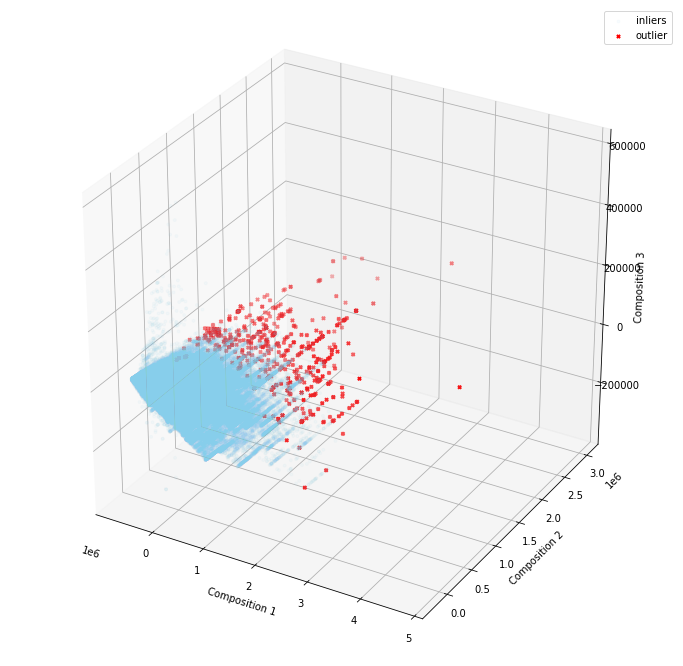

In [ ]:
outlierDetection.iForestVisualization(df = NCB_Isolation,
                                      index = outlier_index)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


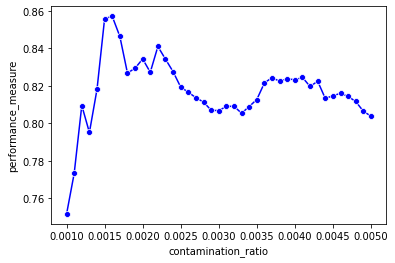

In [ ]:
outlierDetection.iForestRecall(df = iForest_recall)
  # [FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12,
  # the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.]

### 6. 최적의 머신러닝 모델 LightGBM Classifier 적합 후 최적화

> 메소드 내에서 self. 를 통해 클래스 멤버변수에 접근 가능

In [ ]:
# OutlierDetection 함수에서 NCB_MICE_FS_OD 데이터를 완성하여 실행할 것

NCB_MICE_FS_OD = pd.read_csv("/content/drive/MyDrive/NCB_MICE_FS.csv", index_col = False)

In [ ]:
class MachineLearning:
  def __init__(self, df = None):
    self.df = df

# dataCleaning_to_classImbalance()
# NCB_MICE_FS_OD 데이터의 타입 변환 및 소수 범주에 대한 합성과잉표본추출 기법(SMOTE-NC)을 수행하는 함수

  def dataCleaning_to_classImbalance(self, df: pd.DataFrame):

    # 데이터 타입 변환
    df = round(df, 0)
      # [연속형 변수 중 실수를 소수점 첫째 자리에서 정수로 반올림]

    columns_float_list = df.select_dtypes(include = ["float"]).columns.tolist()
    df.loc[:, columns_float_list] = NCB_MICE_FS_OD.loc[:, columns_float_list].astype("int")
      # [실수(float)를 정수(integer)로 타입 변환]

    df.iloc[:, 6:124] = df.iloc[:, 6:124].astype("uint8")
    df["duplicate"] = df["duplicate"].astype("uint8")
      # [더미변수를 8byte의 부호 없는 정수 타입, "uint8"으로 변환]

    X = df.drop(["TARGET", "SK_ID_CURR", "SK_ID_PREV"], axis = 1)
    y = df["TARGET"]
      # [독립변수들과 종속변수 X, y 벡터에 할당]

    columns_dummy_list = X.select_dtypes(include = ["uint8"]).columns.tolist()
    columns_category_list: List = []
    for columns in columns_dummy_list:
      columns_category_list.append(X.columns.get_loc(columns))
      # [범주형 더미변수의 컬럼 번호(위치) 반환]

    # 합성표본추출기법 SMOTE_Nominal Continuous 활용] 5:5 클래스 균형
    smoteNC = SMOTENC(random_state = 2022, k_neighbors = 5, sampling_strategy = "minority",
                      categorical_features = columns_category_list)
    X_smote, y_smote = smoteNC.fit_resample(X, y)

    return X_smote, y_smote


# mutateGeneration()
# "DAYS_BIRTH"로부터 "GENERATION" 세대변수를 파생하는 함수

  def mutateGeneration(self, X: pd.DataFrame):

    X["GENERATION"] = round(X["DAYS_BIRTH"] / 365, 0)

    X["GENERATION"] = X["GENERATION"].apply(lambda age : (age // 10) * 10)
      # [DAYS_BIRTH를 GENERATION으로 파생한 함수를 정의하여 NICE_MICE_FS_OD 데이터 프레임 내 변수(시리즈)에 적용]
    X["GENERATION"] = X["GENERATION"].astype("category")
      # [연속형에서 범주형으로 타입 변환]
    X = pd.get_dummies(X, columns = ["GENERATION"])
      # [더미 변수로 변환]
    X.drop(["DAYS_BIRTH"], axis = 1, inplace = True)
      # [대출신청일까지 살아온 기간을 나타내는 DAYS_BIRTH 제거]

    return X


# LightGradientBoostingTree()
# LightGBM 분류 모델을 적합하고(fitting) performance measure(금융회사의 기대손실)을 예측하는 함수

  def LightGradientBoostingTree(self,
                                X: pd.DataFrame,
                                y: pd.Series,
                                boostMethod: object,
                                threshold: float):

   # 1. train:test 데이터를 5:5 분할
    np.random.seed(2023)
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        stratify = y,
                                                        test_size = 0.5,
                                                        random_state = 2023)
    lgbTree = LGBMClassifier(n_estimators = 100,
                             max_depth = 23,
                             boosting_type = boostMethod,
                             learning_rate = 0.5,
                             random_state = 2023)
      # [boosting_type] "gbdt" xgboost의 gbtree
    lgbTree.fit(X_train, y_train)

  # 2. 범주 결정 확률의 임계값, threshold를 설정하여 예측 : y_pred = lgbTree.predict(X_test)
    y_pred_test = pd.DataFrame(lgbTree.predict_proba(X_test))[1]
      # [리프(터미널) 노드에 있는 TARGET 1의 클래스 비율 "p(y = 1) / p(y)"을 활용하여 예측확률을 반환]
    y_pred = y_pred_test.copy()
    y_pred[y_pred > threshold] = 1
      # [클래스 분류확률이 임계값을 초과하면 1로 예측]
    y_pred[y_pred <= threshold] = 0
      # [클래스 분류확률이 임계값 이하이면 0으로 예측]

    y_pred = np.array(y_pred)
    y_test = np.array(y_test)

    TP, FN, FP, TN = 0, 0, 0, 0

    for i in range(len(y_pred)):
      if y_test[i] == y_pred[i] == 1:
        TP += 1
      if y_test[i] == 1 and y_pred[i] == 0:
        FN += 1
      if y_test[i] == 0 and y_pred[i] == 1:
        FP += 1
      if y_test[i] == 0 and y_pred[i] == 0:
        TN += 1

  # 3. 혼동행렬(모형채점표) 생성 후 F-1.35점수 등 성능평가지표 출력 : 기술지표
    confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)
    Accuracy = (TP + TN) / (TP + FN + FP + TN)
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)

    print(confusionMatrix)
    print("F-1.35 점수 :", ((1+(1.35**2)) * Precision * Recall) / ((1.35**2)*Precision + Recall))
    print("정확도 :", Accuracy)
    print("정밀도 :", Precision)
    print("재현율 :", Recall)

  # 4. 특징 중요도 : "split" or "gain" 빈도, feature의 split에 대한 기여도
    plot_importance(lgbTree, max_num_features = 30)
    plt.show

  # 5. 분류 가중치 설정 후 단위 조정 : 자연로그 변환
    DBSavingsBank = np.log([1106, 54157]).round()
    DBInsurance = np.log([6981, 488399]).round()
      # [백만 원 단위의 2021년도 결산 손익계산서 계정과목]

  # 7. DB계열 제2금융권 개인신용대출의 기대손실(오분류비용) 추정 : 사업지표
    print(f"DB저축은행의 오분류비용은 {-sum(confusionMatrix[[0,1], [1,0]] * DBSavingsBank)}, DB손해보험의 오분류비용은 {-sum(confusionMatrix[[0,1], [1,0]] * DBInsurance)}")
      # 분류가중치 행렬 및 오분류 데이터 행렬의 곱 연산
      # 행렬곱을 numpy module(np.matmul)없이 구현하는 방법 : [ [sum(i * list_prediction) for i in index] for index in zip(*list_bank, *list_insurance) ]

In [ ]:
ML = MachineLearning()

In [ ]:
X_smote, y_smote = ML.dataCleaning_to_classImbalance(df = NCB_MICE_FS_OD)

In [ ]:
X_smote = ML.mutateGeneration(X = X_smote)
  # [PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.]
  # [Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`]

<ipython-input-16-649d4be735a7>:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X["GENERATION"] = round(X["DAYS_BIRTH"] / 365, 0)


[[123862  20030]
 [ 11853 132038]]
F-1.35 점수 : 0.8784855327885341
정확도 : 0.8892116629543788
정밀도 : 0.9126625649338688
재현율 : 0.860798376560198
DB저축은행의 오분류비용은 -270593.0, DB손해보험의 오분류비용은 -334359.0


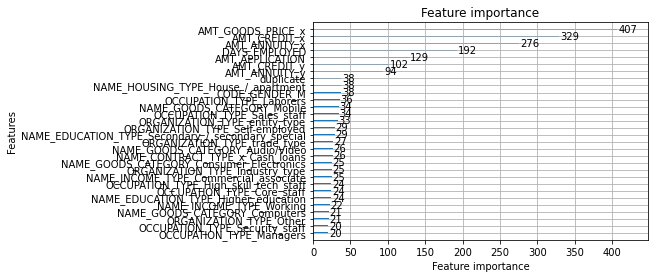

In [ ]:
ML.LightGradientBoostingTree(X_smote, y_smote, "gbdt", 0.5)

In [ ]:
class MachineLearnerFitting:
  def __init__(self, X, y, boostingMethod):
    self.X = X
    self.y = y
    self.boostingMethod = boostingMethod


# LGBM_performance_measure()
# LightGBM 분류모델의 성능평가지표를 반환하는 함수

  def LGBM_performance_measure(self, threshold: float):

   # 1. train:test 데이터를 5:5 분할
    np.random.seed(2023)
    X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                        self.y,
                                                        stratify = self.y,
                                                        test_size = 0.5,
                                                        random_state = 2023)
    lgbTree = LGBMClassifier(n_estimators = 100,
                             max_depth = 23,
                             boosting_type = self.boostingMethod,
                             learning_rate = 0.5,
                             random_state = 2023)
      # [boosting_type] "gbdt" xgboost의 gbtree
    lgbTree.fit(X_train, y_train)

  # 2. 범주 결정 확률의 임계값, threshold를 설정하여 예측 : y_pred = lgbTree.predict(X_test)
    y_pred_test = pd.DataFrame(lgbTree.predict_proba(X_test))[1]
      # [리프(터미널) 노드에 있는 TARGET 1의 클래스 비율 "p(y = 1) / p(y)"을 활용하여 예측확률을 반환]
    y_pred = y_pred_test.copy()
    y_pred[y_pred > threshold] = 1
      # [클래스 분류확률이 임계값을 초과하면 1로 예측]
    y_pred[y_pred <= threshold] = 0
      # [클래스 분류확률이 임계값 이하이면 0으로 예측]

    y_pred = np.array(y_pred)
    y_test = np.array(y_test)

    TP, FN, FP, TN = 0, 0, 0, 0

    for i in range(len(y_pred)):
      if y_test[i] == y_pred[i] == 1:
        TP += 1
      if y_test[i] == 1 and y_pred[i] == 0:
        FN += 1
      if y_test[i] == 0 and y_pred[i] == 1:
        FP += 1
      if y_test[i] == 0 and y_pred[i] == 0:
        TN += 1

  # 3. 혼동행렬(모형채점표) 생성 후 F-1.35점수 등 성능평가지표 출력 : 기술지표
    confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    F_Beta = ((1+(1.35**2)) * Precision * Recall) / ((1.35**2)*Precision + Recall)

  # 4. 분류 가중치 설정 후 단위 조정 : 자연로그 변환
    DBSavingsBank = np.log([1106, 54157]).round()
    DBInsurance = np.log([6981, 488399]).round()
      # [백만 원 단위의 2021년도 결산 손익계산서 계정과목]

  # 5. DB계열 제2금융권 개인신용대출의 기대손실(오분류비용) 추정 : 사업지표
      # [분류가중치 행렬 및 오분류 데이터 행렬의 곱 연산]

    return F_Beta, -sum(confusionMatrix[[0,1], [1,0]] * DBSavingsBank), -sum(confusionMatrix[[0,1], [1,0]] * DBInsurance)


# LGBM_threshold_gridsearch()
# LightGBM 분류모델의 하이퍼파라미터로 임계값을 그리드 서치하는 함수

  def LGBM_threshold_gridsearch(self):

  # 6. 분류 임계값(class probability, decision threshold, cutoff)에 대하여 0.01:0.99까지 0.01씩 증가하는 수열(리스트 내 99개의 원소) 설정
    contain: List = []
    float: float = 0.01
    while float:
      if float < 1:
        contain.append(float)
        float += 0.01
        float = round(float, 3)
      else:
        # float = 1:
        break

    # 길이 99의 빈 벡터(리스트) 생성
    vector = list(np.zeros(shape = 99))
    # 임계값에 따른 성능평가지표(가중치 조정한 정밀도와 재현율의 조화평균과 각 금융회사의 오분류비용(예측 기대손실)) 데이터 프레임 생성
    Threshold_Metric = pd.DataFrame(data = np.array([contain, vector, vector, vector]).reshape(4, 99).T,
                                    columns = ["Threshold",
                                               "F_Beta_score",
                                               "SavingsBank_Expected_Loss",
                                               "Insurance_Expected_Loss"])

  # 7. Light GBM의 분류확률 임계값 수열(0.01:0.99)에 따른 LightGBM 모델성능평가지표를 데이터프레임에 저장
    i: int = 0
      # [index 정수형 타입 선언 후 0 할당(초기화)]

    for float in contain:
      globals()["F_Beta_{}".format(i)], globals()["SavingsBank_Loss_{}".format(i)], globals()["Insurance_Loss_{}".format(i)] = MachineLearnerFitting(self.X, self.y, self.boostingMethod).LGBM_performance_measure(float)

      Threshold_Metric.iloc[i, 1] = globals()["F_Beta_{}".format(i)]
      Threshold_Metric.iloc[i, 2] = globals()["SavingsBank_Loss_{}".format(i)]
      Threshold_Metric.iloc[i, 3] = globals()["Insurance_Loss_{}".format(i)]

      i += 1

    return Threshold_Metric


# LGBM_gridsearch_visualization()
# 임계값 조정에 따른 LightGBM 분류모델의 성능평가지표의 변동 시각화하는 함수

  def LGBM_gridsearch_visualization(self, df: pd.DataFrame):

    fig, ax1 = plt.subplots(figsize = (8, 6))
    color_1 = "tab:blue"
    color_3 = "tab:green"

    ax1.set_title("Expected costs and F-1.35 score in DB Financial Corporation")
    ax1.set_xlabel("threshold")
    ax1.set_ylabel("misclassification costs")

    # 저축은행의 오분류비용 lineplot
    Savingsbank, = ax1.plot(
        df["Threshold"],
        df["SavingsBank_Expected_Loss"],
        marker = 's',
        markersize = 3,
        color = color_1,
        label = "savingsbank")

    # 손해보험의 오분류비용 lineplot
    Insurance, = ax1.plot(
        df["Threshold"],
        df["Insurance_Expected_Loss"],
        marker = 'p',
        markersize = 3,
        color = color_3,
        label = "insurance")

    ax1.tick_params(axis = "y")
    ax1.legend(handles = [Savingsbank, Insurance])

    ax2 = ax1.twinx()
    color_2 = "tab:orange"
    ax2.set_ylabel("F-1.35 score")

    # F-beta 점수 lineplot (beta = 1.35)
    ax2.plot(
        df["Threshold"],
        df["F_Beta_score"],
        marker = 'o',
        markersize = 3,
        color = color_2)
    ax2.tick_params(axis = "y")

    fig.tight_layout()
    plt.show()

In [ ]:
MLfit = MachineLearnerFitting(X_smote, y_smote, "gbdt")

In [ ]:
lgbm_threshold_metric = MLfit.LGBM_threshold_gridsearch()

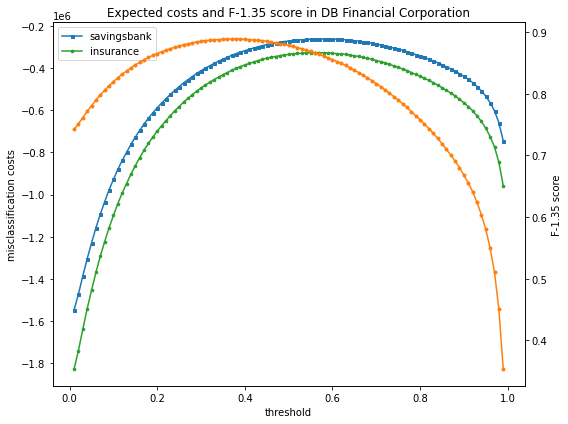

In [ ]:
MLfit.LGBM_gridsearch_visualization(df = lgbm_threshold_metric)

In [ ]:
lgbm_threshold_metric[(lgbm_threshold_metric["Threshold"] == 0.36) |
                      (lgbm_threshold_metric["Threshold"] == 0.37) |
                      (lgbm_threshold_metric["Threshold"] == 0.38) |
                      (lgbm_threshold_metric["Threshold"] == 0.39) |
                      (lgbm_threshold_metric["Threshold"] == 0.4)]

,Threshold,F_Beta_score,SavingsBank_Expected_Loss,Insurance_Expected_Loss
35,0.36,0.888593,-347950.0,-420322.0
36,0.37,0.888961,-338671.0,-409673.0
37,0.38,0.889036,-330349.0,-400179.0
38,0.39,0.888752,-323288.0,-392200.0
39,0.40,0.888326,-316497.0,-384559.0


[[130463  13429]
 [ 21486 122405]]
F-1.35 점수 : 0.8890361628516541
정확도 : 0.8786759468071429
정밀도 : 0.8585972925126194
재현율 : 0.9066730603508186
DB저축은행의 오분류비용은 -330349.0, DB손해보험의 오분류비용은 -400179.0


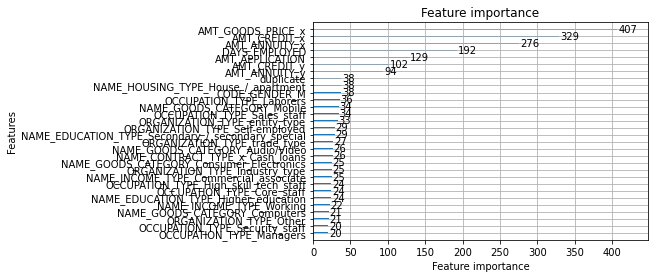

In [ ]:
ML.LightGradientBoostingTree(X_smote, y_smote, "gbdt", 0.38)
  # [연체로 예측된 고객 100명 중 실제 연체 고객이 91명인 경우] 재현율
  # [실제 연체 고객이 100명 중 연체로 예측된 고객이 86명인 경우] 정밀도

### 7. 통계적 가설검정을 통한 신용위험고객에 대한 인사이트 제시
> 다변량 분산분석(MANOVA)과 사후검정(ANOVA, TukeyHSD test), 피셔의 정확검정

In [ ]:
class HypothesisTest():
  def __init__(self, riskClient: pd.DataFrame, stableClient: pd.DataFrame, stable_risk_merge = None,
               n_unexpected_risk = None, n_row_risk = None, n_unexpected_stable = None, n_row_stable = None):
    self.riskClient = riskClient
    self.stableClient = stableClient
    self.stable_risk_merge = stable_risk_merge

    self.n_unexpected_risk = n_unexpected_risk
    self.n_row_risk = n_row_risk
    self.n_unexpected_stable = n_unexpected_stable
    self.n_row_stable = n_row_stable


# dummy_get_category()
# 더미변수를 범주형 변수로 변환하는 함수

  def dummy_get_category(self, X: pd.DataFrame):

    # 세대(연령대) 더미변수 20, 30, 40, 50, 60대를 하나의 범주형 변수로 통합
    X["GENERATION"] = 0

    for i in [20.0, 30.0, 40.0, 50.0, 60.0]:
      X.loc[X[X["GENERATION_{}".format(i)] == 1].index.tolist(), "GENERATION"] = i
    for i in [20.0, 30.0, 40.0, 50.0, 60.0]:
      X.drop(["GENERATION_{}".format(i)], axis = 1, inplace = True)
    X["GENERATION"] = X["GENERATION"].astype("category")

    # 교육수준 더미변수를 하나의 범주형 변수로 통합
    X["EDUCATION_TYPE"] = 0

    for i in ["Higher education", "Secondary / secondary special"]:
      X.loc[X[X["NAME_EDUCATION_TYPE_{}".format(i)] == 1].index.tolist(), "EDUCATION_TYPE"] = i
        # [교육수준 high/secondary 둘 중 어떤 범주에도 포함되지 않는 고객 3,110명의 데이터를 0(결측값) 처리]
    for i in ["Higher education", "Secondary / secondary special"]:
      X.drop(["NAME_EDUCATION_TYPE_{}".format(i)], axis = 1, inplace = True)
    X["EDUCATION_TYPE"] = X["EDUCATION_TYPE"].astype("category")

    # 업종 유형 ORGANIZATION_TYPE
    X["ORGANIZATION_TYPE"] = 0

    for i in ["entity_type", "Medicine", "trade_type", "Industry_type", "Self-employed"]:
      X.loc[X[X["ORGANIZATION_TYPE_{}".format(i)] == 1].index.tolist(), "ORGANIZATION_TYPE"] = i
    for i in ["entity_type", "Medicine", "trade_type", "Industry_type", "Self-employed"]:
      X.drop(["ORGANIZATION_TYPE_{}".format(i)], axis = 1, inplace = True)
    X["ORGANIZATION_TYPE"] = X["ORGANIZATION_TYPE"].astype("category")

    # 과거 신용대출받은 대금으로 결제한 소비재의 더미변수 : What kind of goods did the client apply for in the previous application
    X["NAME_GOODS_CATEGORY"] = 0

    for i in ["Mobile", "Computers", "Construction Materials", "Audio/Video", "Consumer Electronics", "Clothing and Accessories"]:
      X.loc[X[X["NAME_GOODS_CATEGORY_{}".format(i)] == 1].index.tolist(), "NAME_GOODS_CATEGORY"] = i
    for i in ["Mobile", "Computers", "Construction Materials", "Audio/Video", "Consumer Electronics", "Clothing and Accessories"]:
      X.drop(["NAME_GOODS_CATEGORY_{}".format(i)], axis = 1, inplace = True)

    X["NAME_GOODS_CATEGORY"] = X["NAME_GOODS_CATEGORY"].astype("category")

    # 직업 유형 OCCUPATION_TYPE
    X["OCCUPATION_TYPE"] = 0

    for i in ["Laborers", "High skill tech staff", "Sales staff", "Core staff"]:
      X.loc[X[X["OCCUPATION_TYPE_{}".format(i)] == 1].index.tolist(), "OCCUPATION_TYPE"] = i
    for i in ["Laborers", "High skill tech staff", "Sales staff", "Core staff"]:
      X.drop(["OCCUPATION_TYPE_{}".format(i)], axis = 1, inplace = True)

    X["OCCUPATION_TYPE"] = X["OCCUPATION_TYPE"].astype("category")

    # 소득유형 더미변수를 하나의 범주형 변수로 통합 INCOME_TYPE
    X["INCOME_TYPE"] = 0

    for i in ["Commercial associate", "Working"]:
      X.loc[X[X["NAME_INCOME_TYPE_{}".format(i)] == 1].index.tolist(), "INCOME_TYPE"] = i
    for i in ["Commercial associate", "Working"]:
      X.drop(["NAME_INCOME_TYPE_{}".format(i)], axis = 1, inplace = True)

    X["INCOME_TYPE"] = X["INCOME_TYPE"].astype("category")

    X[["duplicate", "NAME_HOUSING_TYPE_House / apartment", "NAME_CONTRACT_TYPE_x_Cash loans", "CODE_REJECT_REASON_CLIENT"]] = \
    X[["duplicate", "NAME_HOUSING_TYPE_House / apartment", "NAME_CONTRACT_TYPE_x_Cash loans", "CODE_REJECT_REASON_CLIENT"]].astype("category")


# featureImportance_selection()
# LightGBM 모델의 트리 분할에 기여도가 높은(지니 지수 기반의 불순도를 낮추는) 상위 특성변수를 선택하는 함수

  def featureImportance_selection(self, featureImportantcolumn: List):

    self.riskClient = self.riskClient.loc[:, featureImportantcolumn]
    self.stableClient = self.stableClient.loc[:, featureImportantcolumn]

    HypothesisTest(self.riskClient, self.stableClient).dummy_get_category(self.riskClient)
    HypothesisTest(self.riskClient, self.stableClient).dummy_get_category(self.stableClient)

    # return self.riskClient, self.stableClient


# preconditional_test()
# 정규성 검정, 등분산성 검정, 다변량 분산분석을 수행하는 함수

  def preconditional_test(self):

    # 전제조건 1: 정규성 검정(Anderson-Darling Test)
    for column in self.riskClient.select_dtypes(include = ["int64", "float64"]).columns.tolist():
      anderson_result = anderson(self.riskClient[column], dist = "norm")
      if anderson_result[0] > anderson_result[1][2]:
        # [0] 검정통계량(statistic)
        # [1] 임계값(유의수준 a, 5% 이상이 되는 자리값, critical_values)
        # [2] 임계값의 유의확률 p-value
        # [1][2] 정규성 검정통계량이 유의수준 5% 검정통계량보다 클 경우, 정규분포를 따름
        print(f"{column}변수는 정규분포를 따르지 않는다")
      else:
        print(f"{column}변수는 정규분포를 따른다")
    print("\n")

    # 전제 조건 2: 등분산성 검정(정규성이 성립하지 않을 경우 Levene Test)
    for column_1 in self.riskClient.select_dtypes(include = ["int64", "float64"]).columns.tolist():
      for column_2 in self.riskClient.select_dtypes(include = ["int64", "float64"]).columns.tolist():
        if column_1 != column_2:
          levene_result = levene(self.riskClient[column_1], self.riskClient[column_2])

          if levene_result[1] < 0.05:
            print(f"{column_1}변수와 {column_2}변수의 이분산성은 통계적으로 유의하다")
          else:
            print(f"{column_1}변수와 {column_2}변수은 등분산성 조건이 성립한다")

        else: # column_1 == column_2:
          pass


  # 전제 조건 3: 독립성 가정

  def MANOVA(self):

  # 신용위험고객(risk credit)과 안정위험고객(stable credit)의 차이에 대한 원인 가설검정

  # 1) duplicate 0 > 1
  # 2) Housing_TYPE 0 < 1
  # 3) Name_contract_type_cash loan 0 < 1
  # 4) code_reject_reason_client 0 > 1
  # 5) generation 30
  # 6) education_type  secondary
  # 7) organization  entity
  # 8) name_goods_category  mobile
  # 9) occupation  laborers
  # 10) income  working

    stableClient_control = self.stableClient.loc[
        (self.stableClient["duplicate"] == 1) &
        (self.stableClient["NAME_HOUSING_TYPE_House / apartment"] == 1) &
        (self.stableClient["NAME_CONTRACT_TYPE_x_Cash loans"] == 1) &
        (self.stableClient["CODE_REJECT_REASON_CLIENT"] == 0) &
        (self.stableClient["GENERATION"] == 30) &
        (self.stableClient["EDUCATION_TYPE"] == "Secondary / secondary special") &
        (self.stableClient["ORGANIZATION_TYPE"] == "entity_type") &
        (self.stableClient["NAME_GOODS_CATEGORY"] == "Mobile") &
        (self.stableClient["OCCUPATION_TYPE"] == "Laborers") &
        (self.stableClient["INCOME_TYPE"]=="Working"),
        ["AMT_GOODS_PRICE_x",	"AMT_CREDIT_x",	"AMT_ANNUITY_x",	"DAYS_EMPLOYED",	"AMT_APPLICATION",	"AMT_ANNUITY_y",	"AMT_CREDIT_y"]]

    riskClient_control = self.riskClient.loc[
        (self.riskClient["duplicate"] == 1) &
        (self.riskClient["NAME_HOUSING_TYPE_House / apartment"] == 1) &
        (self.riskClient["NAME_CONTRACT_TYPE_x_Cash loans"] == 1) &
        (self.riskClient["CODE_REJECT_REASON_CLIENT"] == 0) &
        (self.riskClient["GENERATION"] == 30) &
        (self.riskClient["EDUCATION_TYPE"] == "Secondary / secondary special") &
        (self.riskClient["ORGANIZATION_TYPE"] == "entity_type") &
        (self.riskClient["NAME_GOODS_CATEGORY"] == "Mobile") &
        (self.riskClient["OCCUPATION_TYPE"] == "Laborers") &
        (self.riskClient["INCOME_TYPE"]=="Working"),
        ["AMT_GOODS_PRICE_x",	"AMT_CREDIT_x",	"AMT_ANNUITY_x",	"DAYS_EMPLOYED",	"AMT_APPLICATION",	"AMT_ANNUITY_y",	"AMT_CREDIT_y"]]

    stableClient_control["TARGET"] = 0
    riskClient_control["TARGET"] = 1

    self.stable_risk_merge = pd.concat([stableClient_control, riskClient_control], axis = 0)
    self.stable_risk_merge["TARGET"] = self.stable_risk_merge["TARGET"].astype("category")

    manova_result = MANOVA.from_formula(
        "AMT_GOODS_PRICE_x + AMT_CREDIT_x + AMT_ANNUITY_x + DAYS_EMPLOYED + AMT_APPLICATION + AMT_ANNUITY_y + AMT_CREDIT_y ~ TARGET",
        data = self.stable_risk_merge)
    print(manova_result.mv_test())
      # [AttributeError: 'function' object has no attribute 'from_formula']
      # [TypeError: mv_test() missing 1 required positional argument: 'self']


# ANOVA_TukeyHSD()
# 사후검정을 수행하는 함수

  def ANOVA_TukeyHSD(self):

    # oneway ANOVA 사후검정 수행 : stats.f_oneway()
    linearModel = ols("AMT_GOODS_PRICE_x ~ TARGET", data = self.stable_risk_merge).fit()
    anova_test = anova_lm(linearModel, typ = 2)
    print("AMT_GOODS_PRICE_x",  anova_test.iloc[0, -1])
    linearModel = 0

    linearModel = ols("AMT_CREDIT_x ~ TARGET", data = self.stable_risk_merge).fit()
    anova_test = anova_lm(linearModel, typ = 2)
    print("AMT_CREDIT_x", anova_test.iloc[0, -1])
    linearModel = 0

    linearModel = ols("AMT_ANNUITY_x ~ TARGET", data = self.stable_risk_merge).fit()
    anova_test = anova_lm(linearModel, typ = 2)
    print("AMT_ANNUITY_x", anova_test.iloc[0, -1])
    linearModel = 0

    linearModel = ols("DAYS_EMPLOYED ~ TARGET", data = self.stable_risk_merge).fit()
    anova_test = anova_lm(linearModel, typ = 2)
    print("DAYS_EMPLOYED", anova_test.iloc[0, -1])
    linearModel = 0

    linearModel = ols("AMT_APPLICATION ~ TARGET", data = self.stable_risk_merge).fit()
    anova_test = anova_lm(linearModel, typ = 2)
    print("AMT_APPLICATION", anova_test.iloc[0, -1])
    linearModel = 0

    linearModel = ols("AMT_ANNUITY_y ~ TARGET", data = self.stable_risk_merge).fit()
    anova_test = anova_lm(linearModel, typ = 2)
    print("AMT_ANNUITY_y", anova_test.iloc[0, -1])
    linearModel = 0

    linearModel = ols("AMT_CREDIT_y ~ TARGET", data = self.stable_risk_merge).fit()
    anova_test = anova_lm(linearModel, typ = 2)
    print("AMT_CREDIT_y", anova_test.iloc[0, -1], "\n")
    linearModel = 0

    # Tukey HSD
    for IV in ["AMT_GOODS_PRICE_x", "AMT_CREDIT_x", "AMT_ANNUITY_x", "DAYS_EMPLOYED", "AMT_APPLICATION", "AMT_ANNUITY_y", "AMT_CREDIT_y"]:
      tukeyHSD = pairwise_tukeyhsd(endog = self.stable_risk_merge[IV],
                                   groups = self.stable_risk_merge["TARGET"],
                                   alpha = 0.05)

      print(IV)
      print(tukeyHSD)
        # [tukeyHSD = mc.MultiComparison]
        # [ValueError: DataFrame constructor not properly called!]


  def LogisticRegression(self):

    for IV in ["DAYS_EMPLOYED", "AMT_APPLICATION", "AMT_ANNUITY_y", "AMT_CREDIT_y"]:
      y = self.stable_risk_merge["TARGET"]
      X = self.stable_risk_merge[IV]

      logisticModel = sm.Logit(y, X)
      logit_result = logisticModel.fit()

      print(logit_result.pvalues)
      print(np.exp(logit_result.params))
        # [로그우도에서 오즈비 변환]
        # [ValueError: endog must be in the unit interval.]
      print((1 - np.exp(logit_result.params)) * 100)


# unexpectedRiskGroupRatio(), FisherExactTest()
# 대립가설을 채택함에 따라 3년간 재직 중인 이사/영업직/엔지니어 중 한가지 직업을 가진 commercial associate 유형의 소득을 취득하는 고객은 우량 또는 중신용자 집단에서 비율이 더 높다

  def unexpectedRiskGroupRatio(self):

    self.n_unexpected_risk = len(self.riskClient[
        (self.riskClient["DAYS_EMPLOYED"] >= 1095) &
        (self.riskClient["INCOME_TYPE"] == "Commercial associate") &
        ((self.riskClient["OCCUPATION_TYPE"] == "Core staff") | (self.riskClient["OCCUPATION_TYPE"] == "Sales staff") | (self.riskClient["OCCUPATION_TYPE"] == "High skill tech staff"))
      ])
    self.n_row_risk = len(self.riskClient)

    self.n_unexpected_stable = len(self.stableClient[
        (self.stableClient["DAYS_EMPLOYED"] >= 1095) &
        (self.stableClient["INCOME_TYPE"] == "Commercial associate") &
        ((self.stableClient["OCCUPATION_TYPE"] == "Core staff") | (self.stableClient["OCCUPATION_TYPE"] == "Sales staff") | (self.stableClient["OCCUPATION_TYPE"] == "High skill tech staff"))
      ])
    self.n_row_stable = len(self.stableClient)


  def FisherExactTest(self):

    contingencyTable = pd.DataFrame(
        data = [[self.n_unexpected_risk, self.n_row_risk],
                [self.n_unexpected_stable, self.n_row_stable]],
        index = ["risk credit", "stable credit"],
        columns = ["cashflow", "not cashflow"]
    )
    print(contingencyTable)

    fisher_exact_result = fisher_exact(contingencyTable, alternative = "less")
      # [H0 : p_risk >= p_stable]
      # [H1 : p_risk < p_stable]
    if fisher_exact_result[1] < 0.05:
      print(f"신용위험고객과 안정고객의 현금흐름이 원활한 집단에 대한 모비율은 통계적으로 유의한 차이가 있다")
    else:
      print(f"신용위험고객과 안정고객의 현금흐름이 원활한 집단에 대한 모비율은 동질적이다")


In [ ]:
Insight = HypothesisTest(
    riskClient = pd.read_csv("/content/drive/MyDrive/creditRisk_client.csv", index_col = False),
    stableClient = pd.read_csv("/content/drive/MyDrive/stableCredit_client.csv", index_col = False)
)

In [ ]:
Insight.featureImportance_selection(
    featureImportantcolumn = [
        "AMT_GOODS_PRICE_x", "AMT_CREDIT_x",  "AMT_ANNUITY_x", "DAYS_EMPLOYED", "AMT_APPLICATION", "AMT_ANNUITY_y", "AMT_CREDIT_y",
        "duplicate", "GENERATION_20.0", "GENERATION_30.0", "GENERATION_40.0", "GENERATION_50.0", "GENERATION_60.0",
        "NAME_EDUCATION_TYPE_Higher education", "NAME_EDUCATION_TYPE_Secondary / secondary special",
        "ORGANIZATION_TYPE_entity_type", "ORGANIZATION_TYPE_Medicine", "ORGANIZATION_TYPE_trade_type", "ORGANIZATION_TYPE_Industry_type","OCCUPATION_TYPE_Laborers", "ORGANIZATION_TYPE_Self-employed", "OCCUPATION_TYPE_High skill tech staff", "OCCUPATION_TYPE_Sales staff", "OCCUPATION_TYPE_Core staff",
        "NAME_INCOME_TYPE_Commercial associate", "NAME_INCOME_TYPE_Working", "NAME_HOUSING_TYPE_House / apartment", "NAME_CONTRACT_TYPE_x_Cash loans", "CODE_REJECT_REASON_CLIENT",
        "NAME_GOODS_CATEGORY_Mobile", "NAME_GOODS_CATEGORY_Computers", "NAME_GOODS_CATEGORY_Construction Materials", "NAME_GOODS_CATEGORY_Audio/Video", "NAME_GOODS_CATEGORY_Clothing and Accessories", "NAME_GOODS_CATEGORY_Consumer Electronics"
])

In [ ]:
Insight.preconditional_test()

AMT_GOODS_PRICE_x변수는 정규분포를 따르지 않는다
AMT_CREDIT_x변수는 정규분포를 따르지 않는다
AMT_ANNUITY_x변수는 정규분포를 따르지 않는다
DAYS_EMPLOYED변수는 정규분포를 따르지 않는다
AMT_APPLICATION변수는 정규분포를 따르지 않는다
AMT_ANNUITY_y변수는 정규분포를 따르지 않는다
AMT_CREDIT_y변수는 정규분포를 따르지 않는다


AMT_GOODS_PRICE_x변수와 AMT_CREDIT_x변수의 이분산성은 통계적으로 유의하다
AMT_GOODS_PRICE_x변수와 AMT_ANNUITY_x변수의 이분산성은 통계적으로 유의하다
AMT_GOODS_PRICE_x변수와 DAYS_EMPLOYED변수의 이분산성은 통계적으로 유의하다
AMT_GOODS_PRICE_x변수와 AMT_APPLICATION변수의 이분산성은 통계적으로 유의하다
AMT_GOODS_PRICE_x변수와 AMT_ANNUITY_y변수의 이분산성은 통계적으로 유의하다
AMT_GOODS_PRICE_x변수와 AMT_CREDIT_y변수의 이분산성은 통계적으로 유의하다
AMT_CREDIT_x변수와 AMT_GOODS_PRICE_x변수의 이분산성은 통계적으로 유의하다
AMT_CREDIT_x변수와 AMT_ANNUITY_x변수의 이분산성은 통계적으로 유의하다
AMT_CREDIT_x변수와 DAYS_EMPLOYED변수의 이분산성은 통계적으로 유의하다
AMT_CREDIT_x변수와 AMT_APPLICATION변수의 이분산성은 통계적으로 유의하다
AMT_CREDIT_x변수와 AMT_ANNUITY_y변수의 이분산성은 통계적으로 유의하다
AMT_CREDIT_x변수와 AMT_CREDIT_y변수의 이분산성은 통계적으로 유의하다
AMT_ANNUITY_x변수와 AMT_GOODS_PRICE_x변수의 이분산성은 통계적으로 유의하다
AMT_ANNUITY_x변수와 AMT_CREDIT_x변수의 이분산성은 통계적으로 유의하다
AMT_ANNUITY_x변수와 DAYS_EMPLOYED변수의 이분산

In [ ]:
Insight.MANOVA()

                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.6397 7.0000 717.0000 57.6890 0.0000
         Pillai's trace 0.3603 7.0000 717.0000 57.6890 0.0000
 Hotelling-Lawley trace 0.5632 7.0000 717.0000 57.6890 0.0000
    Roy's greatest root 0.5632 7.0000 717.0000 57.6890 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
         TARGET         Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9574 7.0000 717.0000  4.5575 0.0001
         Pillai's trace 0.0426 7.0000 717.0000  4.5575 0.0001
 Hotelling-Lawley trace 0.

In [ ]:
Insight.ANOVA_TukeyHSD()

AMT_GOODS_PRICE_x 0.1198304584642885
AMT_CREDIT_x 0.3152285272556578
AMT_ANNUITY_x 0.10063576834607493
DAYS_EMPLOYED 0.00937252884091028
AMT_APPLICATION 0.0005324297070540005
AMT_ANNUITY_y 0.007864659390089433
AMT_CREDIT_y 0.0005324073645102461 

AMT_GOODS_PRICE_x
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj    lower      upper    reject
-------------------------------------------------------------
     0      1 -90749.0891 0.1198 -205152.29 23654.1118  False
-------------------------------------------------------------
AMT_CREDIT_x
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
     0      1 -63239.5998 0.3152 -186775.9282 60296.7286  False
---------------------------------------------------------------
AMT_ANNUITY_x
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meand

In [ ]:
Insight.LogisticRegression()
  # [0] 유의확률(p-value)
  # [1] 회귀계수
  # [2] 오즈비

Optimization terminated successfully.
         Current function value: 0.252937
         Iterations 7
DAYS_EMPLOYED    1.214688e-39
dtype: float64
DAYS_EMPLOYED    1.002094
dtype: float64
DAYS_EMPLOYED   -0.209391
dtype: float64
Optimization terminated successfully.
         Current function value: 0.204630
         Iterations 7
AMT_APPLICATION    1.650401e-49
dtype: float64
AMT_APPLICATION    1.000079
dtype: float64
AMT_APPLICATION   -0.007942
dtype: float64
Optimization terminated successfully.
         Current function value: 0.177646
         Iterations 7
AMT_ANNUITY_y    6.140765e-51
dtype: float64
AMT_ANNUITY_y    1.000597
dtype: float64
AMT_ANNUITY_y   -0.059723
dtype: float64
Optimization terminated successfully.
         Current function value: 0.202056
         Iterations 7
AMT_CREDIT_y    2.272642e-49
dtype: float64
AMT_CREDIT_y    1.000075
dtype: float64
AMT_CREDIT_y   -0.007506
dtype: float64


In [ ]:
Insight.unexpectedRiskGroupRatio()
Insight.FisherExactTest()

               cashflow  not cashflow
risk credit        3349        131461
stable credit      6026        119514
신용위험고객과 안정고객의 현금흐름이 원활한 집단에 대한 모비율은 통계적으로 유의한 차이가 있다


### 8. 이항로지스틱 회귀분석을 통한 신용평점 스코어링 및 중신용고객 특징 제시

In [ ]:
class CreditScoringSystem(HypothesisTest):
  # 부모 클래스의 메서드를 호출하는 super()

  def __init__(self, riskClient: pd.DataFrame, stableClient: pd.DataFrame,
               stable_risk_join = None,
               High_Dict = None, Middle_Dict = None, Low_Dict = None):
    super().__init__(riskClient, stableClient)
    self.stable_risk_join = stable_risk_join
    self.High_Dict = High_Dict
    self.Middle_Dict = Middle_Dict
    self.Low_Dict = Low_Dict

    # 1. 표준화
    # 2. X 범주형 및 연속형, y 벡터 분할
    # 3. ridge logit reg
    # 4. predict_proba[0]
    # 5. 1 ~ 1000점 변환
    # 6. 고 중 저 신용자 분할
    # 7. credit_risk 고객, TARGET == 1 행 제거
    # 8. 고, 중, 저 DAYS_EMPLOYED 히스토그램

# ImportData()

  def ImportData(self):
    self.riskClient["TARGET"] = 1
    self.stableClient["TARGET"] = 0
    self.stable_risk_join = pd.concat(
        [self.riskClient, self.stableClient],
        axis = 0)


# featureSelection_DummytoCategory()

  def featureSelection_DummytoCategory(self, featureImportantcolumn: List):
    self.stable_risk_join = self.stable_risk_join.loc[:, featureImportantcolumn]
    self.stable_risk_join.iloc[:, 7:36] = self.stable_risk_join.iloc[:, 7:36].astype("category")

    # 더미변수를 다시 범주형으로 변환하는 함수를 적용하면 로지스틱 회귀식 추정이 어려운 파이썬
    # super().dummy_get_category(self.stable_risk_join)
      # [ValueError: Cannot index with multidimensional key]

    self.stable_risk_join.reset_index(drop = True, inplace = True)
    return self.stable_risk_join.info()


# ridgeLogisticRegression()

  def ridgeLogisticRegression(self):

    # 35개의 X 특징벡터 표준화 (X -> X_category, X_numeric -> X_scaled)
    X = self.stable_risk_join.drop("TARGET", axis = 1)
    X.reset_index(drop = True, inplace = True)
      # [InvalidIndexError: Reindexing only valid with uniquely valued Index objects]

    scaler = StandardScaler()
    X_numeric = X.select_dtypes(include = ["int"])
    X_numeric = pd.DataFrame(data = scaler.fit_transform(X_numeric),
                             columns = X_numeric.columns.tolist())
    X_category = X.select_dtypes(include = ["category"])
    X_scaled = pd.concat([X_category, X_numeric], axis = 1, ignore_index = True)

    # 신용위험 TARGET y 벡터 생성
    y = self.stable_risk_join["TARGET"]

    # 릿지(L2 norm 벌점항을 추가한) 로지스틱 회귀식 추정 후 예측확률 predict_proba 생성
    ridge = LogisticRegression(penalty = "l2", C = 1).fit(X_scaled, y)
    predict_proba = pd.DataFrame(ridge.predict_proba(X_scaled)).iloc[:, 0]
    predict_proba = round(predict_proba * 1000)
    #credit_score = round(predict_proba * 1000)
    #print(pd.DataFrame(predict_proba).describe())
    #print(pd.DataFrame(credit_score).describe())

    # return sns.boxplot(predict_proba), predict_proba.describe()

    # 신용평점 predict_proba * 1000값
    self.stable_risk_join["CreditScore"] = predict_proba
    self.stable_risk_join.sort_values(by = "CreditScore", ascending = False, inplace = True)

    self.stable_risk_join["CreditGrade"] = 0
    self.stable_risk_join.iloc[0:115452, -1] = "High"
    self.stable_risk_join.iloc[115452:225190, -1] = "Middle"
    self.stable_risk_join.iloc[225190:250975, -1] = "Low"

    # 신용위험이 있다고 예측된 실제 신용위험 고객 행 데이터 제거
    self.stable_risk_join = self.stable_risk_join[self.stable_risk_join["TARGET"] == 0]
    self.stable_risk_join["MONTH_EMPLOYED"] = self.stable_risk_join["DAYS_EMPLOYED"].apply(lambda x: x / 30.5)

    # One-hot Encoding 범주형으로 되돌리기
    super().dummy_get_category(self.stable_risk_join)

    return self.stable_risk_join


  def class_ratio(self):

    for i in ["High", "Middle", "Low"]:
      globals()["{}_Dict".format(i)] = Counter(round(self.stable_risk_join["MONTH_EMPLOYED"][self.stable_risk_join["CreditGrade"] == i]))
      globals()["{}_Dict".format(i)] = pd.DataFrame.from_dict(globals()["{}_Dict".format(i)], orient = "index").reset_index()

      globals()["{}_Dict".format(i)].columns = ['months', 'freq']
      globals()["{}_Dict".format(i)]["freq"] = globals()["{}_Dict".format(i)]["freq"].apply(lambda x: (x/sum(globals()["{}_Dict".format(i)]["freq"]) * 100))

    self.High_Dict = High_Dict
    self.Middle_Dict = Middle_Dict
    self.Low_Dict = Low_Dict

    return self.High_Dict, self.Middle_Dict, self.Low_Dict


  # 신용평점별 근무일수 시각화
  def days_employed(self):
    fig, axes = plt.subplots(1, 3, figsize = (12, 5))
    #plt.figure(figsize = (12, 5))
    max_freq = max(self.High_Dict["freq"])

    plt.subplot(1, 3, 1)
    plt.bar(self.High_Dict["months"], self.High_Dict["freq"], color = "blue")
    axes[0].set_ylim(0, max_freq)
    #axes[0].set_xlim(0, 350)
    plt.title("Higher credit class")
        # plt.subplot(311)
    plt.axvline(x=12, ymin=0, ymax=1, color='red', linestyle=':')

    plt.subplot(1, 3, 2)
    plt.bar(self.Middle_Dict["months"], self.Middle_Dict["freq"], color = "green")
    axes[1].set_ylim(0, max_freq)
    #axes[1].set_xlim(0, 350)
    plt.title("Middle credit class")
        # plt.subplot(312)
    plt.axvline(x=12, ymin=0, ymax=1, color='red', linestyle=':')

    plt.subplot(1, 3, 3)
    plt.bar(self.Low_Dict["months"], self.Low_Dict["freq"], color = "orange")
    axes[2].set_ylim(0, max_freq)
    #axes[2].set_xlim(0, 350)
        # plt.subplot(313)
    plt.title("Low credit class")
    plt.axvline(x=12, ymin=0, ymax=1, color='red', linestyle=':')

    plt.tight_layout()
    plt.show()


  # NAME_GOODS_CATEGORY 빈도 시각화
  def c_goods_category(self):
    plt.figure(figsize = (14, 8))
    count_goods_category_vis = sns.countplot(x = "NAME_GOODS_CATEGORY", data = self.stable_risk_join)
    return count_goods_category_vis

* A user supplied lambda sequence. Typical usage is to have the program compute its own lambda sequence based on nlambda and lambda.min.ratio. Supplying a value of lambda overrides this. WARNING: use with care. Avoid supplying a single value for lambda (for predictions after CV use predict() instead). Supply instead a decreasing sequence of lambda values. glmnet relies on its warms starts for speed, and its often faster to fit a whole path than compute a single fit.

```
    ridge = sm.Logit(y, X_scaled)
    ridge_result = ridge.fit_regularized(method = "l1", alpha = 0)
    predict_proba = ridge_result.predict(X_scaled)
```

```
    ridge = LogisticRegression(penalty = "l2", C = 1, pos_class = "0").fit(X_scaled, y)
    predict_proba = pd.DataFrame(ridge.predict_proba(X_scaled)).iloc[:, 0]
      # [Python] C = 1 / lambda
      # [R] cv_fit <- glmnet(xx, y, family = "binomial", alpha = 0, lambda = 1)
      # ridge_loss = loss + (lambda * l2_penalty)

      # glm = LogisticRegression().fit(X_scaled, y)
      # predict_prob = pd.DataFrame(glm.predict_proba(X_scaled)).iloc[:, 0]
```

```
    fig, axes = plt.subplots(3, 1)
    # plt.subplot(312)
      # [if nrows = 3, ncols = 1, index = 2 -> 312]

    # rows = 1 ; cols = 3
    # ax1 = fig.add_subplot(rows, cols, 1)

    axes[0].hist(self.stable_risk_join["DAYS_EMPLOYED"][self.stable_risk_join["CreditGrade"] == "High"], color = "blue")
    # plt.subplot(311)
    axes[1].hist(self.stable_risk_join["DAYS_EMPLOYED"][self.stable_risk_join["CreditGrade"] == "Middle"], color = "green")
    # plt.subplot(312)
    axes[2].hist(self.stable_risk_join["DAYS_EMPLOYED"][self.stable_risk_join["CreditGrade"] == "Low"], color = "yellow")
    # plt.subplot(313)

    fig.tight_layout()
    plt.show()
```

In [ ]:
CSS = CreditScoringSystem(
    riskClient = pd.read_csv("/content/drive/MyDrive/creditRisk_client.csv", index_col = False),
    stableClient = pd.read_csv("/content/drive/MyDrive/stableCredit_client.csv", index_col = False)
)

In [ ]:
CSS.ImportData()
  # [ValueError: All objects passed were None]

In [ ]:
CSS.featureSelection_DummytoCategory(
    featureImportantcolumn = [
        "AMT_GOODS_PRICE_x", "AMT_CREDIT_x",  "AMT_ANNUITY_x", "DAYS_EMPLOYED", "AMT_APPLICATION", "AMT_ANNUITY_y", "AMT_CREDIT_y",
        "duplicate", "GENERATION_20.0", "GENERATION_30.0", "GENERATION_40.0", "GENERATION_50.0", "GENERATION_60.0",
        "NAME_EDUCATION_TYPE_Higher education", "NAME_EDUCATION_TYPE_Secondary / secondary special",
        "ORGANIZATION_TYPE_entity_type", "ORGANIZATION_TYPE_Medicine", "ORGANIZATION_TYPE_trade_type", "ORGANIZATION_TYPE_Industry_type","OCCUPATION_TYPE_Laborers", "ORGANIZATION_TYPE_Self-employed", "OCCUPATION_TYPE_High skill tech staff", "OCCUPATION_TYPE_Sales staff", "OCCUPATION_TYPE_Core staff",
        "NAME_INCOME_TYPE_Commercial associate", "NAME_INCOME_TYPE_Working", "NAME_HOUSING_TYPE_House / apartment", "NAME_CONTRACT_TYPE_x_Cash loans", "CODE_REJECT_REASON_CLIENT",
        "NAME_GOODS_CATEGORY_Mobile", "NAME_GOODS_CATEGORY_Computers", "NAME_GOODS_CATEGORY_Construction Materials", "NAME_GOODS_CATEGORY_Audio/Video", "NAME_GOODS_CATEGORY_Clothing and Accessories", "NAME_GOODS_CATEGORY_Consumer Electronics",
        "TARGET"
])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250975 entries, 0 to 250974
Data columns (total 36 columns):
 #   Column                                             Non-Null Count   Dtype   
---  ------                                             --------------   -----   
 0   AMT_GOODS_PRICE_x                                  250975 non-null  int64   
 1   AMT_CREDIT_x                                       250975 non-null  int64   
 2   AMT_ANNUITY_x                                      250975 non-null  int64   
 3   DAYS_EMPLOYED                                      250975 non-null  int64   
 4   AMT_APPLICATION                                    250975 non-null  int64   
 5   AMT_ANNUITY_y                                      250975 non-null  int64   
 6   AMT_CREDIT_y                                       250975 non-null  int64   
 7   duplicate                                          250975 non-null  category
 8   GENERATION_20.0                                    250975 non-nu

In [ ]:
stable_risk_join = CSS.ridgeLogisticRegression()

In [ ]:
stable_risk_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119514 entries, 153352 to 177572
Data columns (total 21 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   AMT_GOODS_PRICE_x                    119514 non-null  int64   
 1   AMT_CREDIT_x                         119514 non-null  int64   
 2   AMT_ANNUITY_x                        119514 non-null  int64   
 3   DAYS_EMPLOYED                        119514 non-null  int64   
 4   AMT_APPLICATION                      119514 non-null  int64   
 5   AMT_ANNUITY_y                        119514 non-null  int64   
 6   AMT_CREDIT_y                         119514 non-null  int64   
 7   duplicate                            119514 non-null  category
 8   NAME_HOUSING_TYPE_House / apartment  119514 non-null  category
 9   NAME_CONTRACT_TYPE_x_Cash loans      119514 non-null  category
 10  CODE_REJECT_REASON_CLIENT            119514 non-null  category


In [ ]:
H, M, L = CSS.class_ratio()

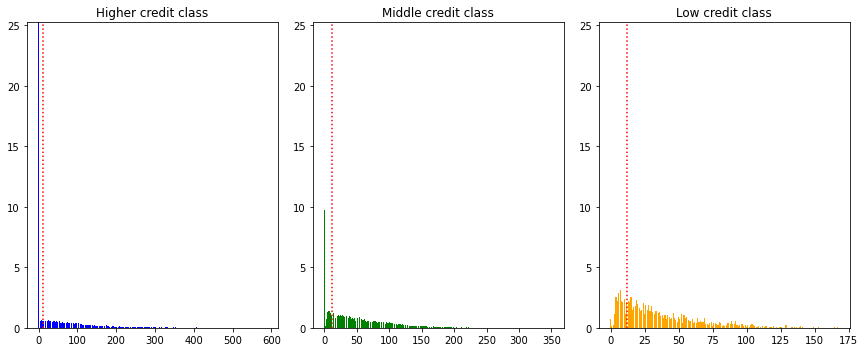

In [ ]:
CSS.days_employed()

<AxesSubplot:xlabel='NAME_GOODS_CATEGORY', ylabel='count'>

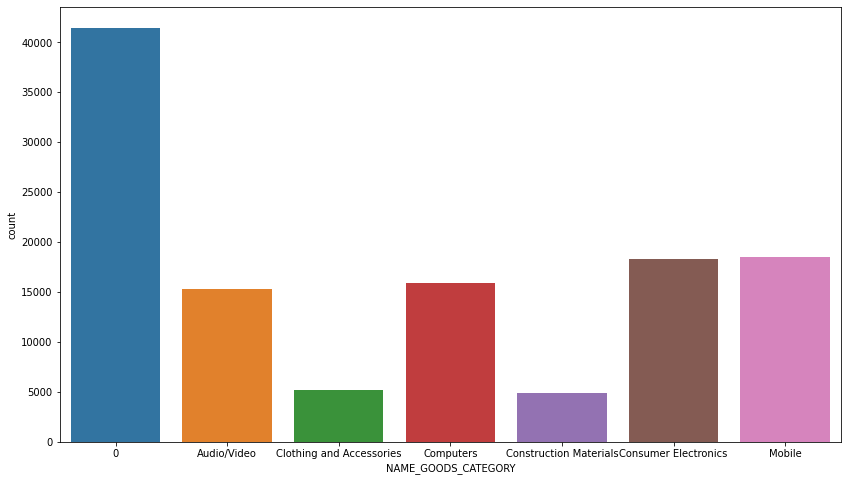

In [ ]:
CSS.c_goods_category()

    H_employed_year = H.sort_values(by = "months", ascending = True).head(13)
    H_employed_year.columns = ["months", "High"]
    H_employed_year.reset_index(drop = True, inplace = True)

    M_employed_year = M.sort_values(by = "months", ascending = True).head(13)
    M_employed_year.reset_index(drop = True, inplace = True)
    L_employed_year = L.sort_values(by = "months", ascending = True).head(13)
    L_employed_year.reset_index(drop = True, inplace = True)

    H_employed_year["Middle"] = 0
    H_employed_year["Low"] = 0
    H_employed_year["Middle"] = M_employed_year["freq"]
    H_employed_year["Low"] = L_employed_year["freq"]

    H_employed_year

    sum(H_employed_year["High"]), sum(H_employed_year["Middle"]), sum(H_employed_year["Low"])

    fig, axes = plt.subplots(1, 3, figsize = (12, 5))
    max_freq = max(H_employed_year["High"])

    plt.subplot(1,3,1)
    plt.bar(H_employed_year["months"], H_employed_year["High"], color = "blue")
    axes[0].set_ylim(0, max_freq)
        # plt.subplot(311)

    plt.subplot(1,3,2)
    plt.bar(H_employed_year["months"], H_employed_year["Middle"], color = "green")
    axes[1].set_ylim(0, max_freq)
        # plt.subplot(312)

    plt.subplot(1,3,3)
    axes[2].bar(H_employed_year["months"], H_employed_year["Low"], color = "yellow")
    axes[2].set_ylim(0, max_freq)
        # plt.subplot(313)

    plt.show()

    ###
    fig, axes = plt.subplots(1, 3)
    # plt.subplot(312)
      # [if nrows = 3, ncols = 1, index = 2 -> 312]
    # rows = 1 ; cols = 3
    # ax1 = fig.add_subplot(rows, cols, 1)
    axes[0].bar(H_employed_year["years"], H_employed_year["High"], color = "blue")
        # plt.subplot(311)
    axes[1].bar(H_employed_year["years"], H_employed_year["Middle"], color = "green")
        # plt.subplot(312)
    axes[2].bar(H_employed_year["years"], H_employed_year["Low"], color = "yellow")
        # plt.subplot(313)
    fig.tight_layout()
    plt.show()

    ###
    fig, axes = plt.subplots(1, 3)
    # plt.subplot(312)
      # [if nrows = 3, ncols = 1, index = 2 -> 312]

        # rows = 1 ; cols = 3
        # ax1 = fig.add_subplot(rows, cols, 1)
    axes[0].bar(H["years"], H["freq"], color = "blue")
        # plt.subplot(311)
    axes[1].bar(M["years"], M["freq"], color = "green")
        # plt.subplot(312)
    axes[2].bar(L["years"], L["freq"], color = "yellow")
        # plt.subplot(313)

    fig.tight_layout()
    plt.show()

    ###
    fig, axes = plt.subplots(1, 3)
    # plt.subplot(312)
      # [if nrows = 3, ncols = 1, index = 2 -> 312]

        # rows = 1 ; cols = 3
        # ax1 = fig.add_subplot(rows, cols, 1)
    axes[0].hist(stable_risk_join["YEARS_EMPLOYED"][stable_risk_join["CreditGrade"] == "High"], color = "blue")
        # plt.subplot(311)
    axes[1].hist(stable_risk_join["YEARS_EMPLOYED"][stable_risk_join["CreditGrade"] == "Middle"], color = "green")
        # plt.subplot(312)
    axes[2].hist(stable_risk_join["YEARS_EMPLOYED"][stable_risk_join["CreditGrade"] == "Low"], color = "yellow")
        # plt.subplot(313)

    fig.tight_layout()
    plt.show()


    Counter(stable_risk_join["CreditGrade"])

### 예측 데이터 반출

In [ ]:
class MLData:

  def __init__(self, X, y, boostingMethod,
               y_pred = None, y_test = None, X_test = None):
    self.X = X
    self.y = y
    self.y_pred = y_pred
    self.y_test = y_test
    self.X_test = X_test
    self.boostingMethod = boostingMethod

# LGBM_performance_measure()
# LightGBM 분류모델의 성능평가지표를 반환하는 함수

  def LGBM_performance_measure(self, threshold: float):

   # 1. train:test 데이터를 5:5 분할
    np.random.seed(2023)
    X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                        self.y,
                                                        stratify = self.y,
                                                        test_size = 0.5,
                                                        random_state = 2023)
    # X_test 인덱스 번호 초기화
    X_test.reset_index(drop = True, inplace = True)
    self.X_test = X_test

    # y_test self화
    self.y_test = y_test

    lgbTree = LGBMClassifier(n_estimators = 100,
                             max_depth = 23,
                             boosting_type = self.boostingMethod,
                             learning_rate = 0.5,
                             random_state = 2023)
      # [boosting_type] "gbdt" xgboost의 gbtree
    lgbTree.fit(X_train, y_train)

  # 2. 범주 결정 확률의 임계값, threshold를 설정하여 예측 : y_pred = lgbTree.predict(X_test)
    y_pred_test = pd.DataFrame(lgbTree.predict_proba(X_test))[1]
      # [리프(터미널) 노드에 있는 TARGET 1의 클래스 비율 "p(y = 1) / p(y)"을 활용하여 예측확률을 반환]
    y_pred = y_pred_test.copy()

    # y_pred self화
    self.y_pred = y_pred

    y_pred[y_pred > threshold] = 1
      # [클래스 분류확률이 임계값을 초과하면 1로 예측]
    y_pred[y_pred <= threshold] = 0
      # [클래스 분류확률이 임계값 이하이면 0으로 예측]

    y_pred = np.array(y_pred)
    y_test = np.array(y_test)

    for i in range(len(y_pred)):
      if y_test[i] == y_pred[i] == 1:
        TP += 1
      if y_test[i] == 1 and y_pred[i] == 0:
        FN += 1
      if y_test[i] == 0 and y_pred[i] == 1:
        FP += 1
      if y_test[i] == 0 and y_pred[i] == 0:
        TN += 1

    X_test["y_test"] = y_test
    X_test["y_pred"] = y_pred
    X_test["ML_reference_prediction"] = ML_reference_prediction

    return X_test

In [ ]:
"""
MLfit = MLData(
    X = pd.read_csv("/content/drive/MyDrive/Xsmote.csv", index_col = False),
    y = pd.read_csv("/content/drive/MyDrive/ysmote.csv", index_col = False),
    boostingMethod = "gbdt")
"""

In [ ]:
MLfit = MLData(
    X = pd.read_csv("/content/drive/MyDrive/archive/data_new_credit_bureau/Xsmote.csv", index_col = False),
    y = pd.read_csv("/content/drive/MyDrive/archive/data_new_credit_bureau/ysmote.csv", index_col = False),
    boostingMethod = "gbdt")

In [ ]:
MLfit.LGBM_performance_measure(threshold = 0.36)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,DAYS_EMPLOYED,AMT_ANNUITY_y,DAYS_BIRTH,AMT_ANNUITY_x,AMT_APPLICATION,AMT_GOODS_PRICE_x,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,...,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,AMT_CREDIT_x,AMT_CREDIT_y,duplicate,y_test,y_pred,ML_reference_prediction
0,2383,13173,11935,26987,123594,450000,0,1,0,1,...,0,0,0,0,532361,128545,1,1,1.0,TP
1,1590,5319,18690,17742,25520,264051,0,1,0,1,...,0,0,0,0,312473,26236,0,1,1.0,TP
2,4114,6302,18373,32895,97376,1125000,0,1,0,1,...,0,0,0,0,1125000,111154,1,0,0.0,TN
3,1426,3407,14894,30158,29349,314468,0,1,0,1,...,0,0,0,0,314468,30063,0,1,1.0,TP
4,1029,11306,12267,7942,64935,185071,0,1,0,1,...,0,0,0,0,185071,65903,0,1,1.0,TP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287778,3084,2219,15821,18482,16065,427500,1,0,0,1,...,0,0,0,0,495216,16065,1,0,1.0,FP
287779,984,8321,13778,25571,65093,450000,0,1,0,1,...,0,0,0,0,544604,71147,0,1,1.0,TP
287780,4545,12056,12031,35740,88483,945000,0,1,0,1,...,0,0,0,0,1052388,95823,0,1,1.0,TP
287781,2216,13578,12567,24370,114901,455621,1,0,0,1,...,0,0,0,0,455621,133262,0,1,1.0,TP


In [ ]:
FinalData = MLfit.LGBM_performance_measure(threshold = 0.36)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
FinalData.to_csv("/content/drive/MyDrive/FinalCreditData.csv", index = False)

### AUROC, Gini-Coefficient

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
# from urllib.request import AbstractBasicAuthHandler
class MLScore:

  def __init__(self, X, y, boostingMethod,
               y_pred = None, y_test = None, X_test = None):
    self.X = X
    self.y = y
    self.y_pred = y_pred
    self.y_test = y_test
    self.X_test = X_test
    self.boostingMethod = boostingMethod


# LGBM_AUROC()
# LightGBM 분류모델의 성능평가지표를 반환하는 함수

  def LGBM_AUROC(self):

   # 1. train:test 데이터를 5:5 분할
    np.random.seed(2023)
    X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                        self.y,
                                                        stratify = self.y,
                                                        test_size = 0.5,
                                                        random_state = 2023)
    # X_test 인덱스 번호 초기화
    X_test.reset_index(drop = True, inplace = True)
    self.X_test = X_test

    # y_test self화
    self.y_test = y_test

    lgbTree = LGBMClassifier(n_estimators = 100,
                             max_depth = 23,
                             boosting_type = self.boostingMethod,
                             learning_rate = 0.5,
                             random_state = 2023)
      # [boosting_type] "gbdt" xgboost의 gbtree
    lgbTree.fit(X_train, y_train)

    # 2. ROC
    y_pred_test = pd.DataFrame(lgbTree.predict_proba(X_test))[1]
    y_pred = y_pred_test.copy()
    self.y_pred = y_pred

    AUROC = roc_auc_score(self.y_test, self.y_pred)
    return AUROC


# LGBM_GINI()
# LightGBM 분류모델의 Gini Coefficient를 반환하는 함수

  def LGBM_GINI(self):

    # Normalized Gini Coefficient
    np.random.seed(2023)

    # 1. actual과 prediction 간 gini coefficient
    assert(len(self.y_test) == len(self.y_pred))
    all = np.asarray(np.c_[self.y_test, self.y_pred, np.arange(len(self.y_test))], dtype = np.float)
    all = all[np.lexsort((all[:,2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum1 = all[:, 0].cumsum().sum() / totalLosses

    giniSum1 -= (len(self.y_test)+1)/2
    a_p_gini = giniSum1 / len(self.y_test)

    # 2. actual과 actual 간 gini coefficient
    assert(len(self.y_test) == len(self.y_test))
    all2 = np.asarray(np.c_[self.y_test, self.y_test, np.arange(len(self.y_test))], dtype = np.float)
    all2 = all2[np.lexsort((all2[:,2], -1 * all2[:, 1]))]
    totalLosses2 = all2[:, 0].sum()
    giniSum2 = all2[:, 0].cumsum().sum() / totalLosses2

    giniSum2 -= (len(self.y_test)+1) / 2
    a_a_gini = giniSum2 / len(self.y_test)

    return a_p_gini / a_a_gini


# LGBM_performance_measure()
# 신용위험 추정확률 분류 임계값을 입력변수로 우량고객 및 불량고객 데이터를 반환하는 함수

  def LGBM_performance_measure(self, threshold: float):

   # 1. train:test 데이터를 5:5 분할
    np.random.seed(2023)
    self.y_pred[self.y_pred > threshold] = 1
      # [클래스 분류확률이 임계값을 초과하면 1로 예측]
    self.y_pred[self.y_pred <= threshold] = 0
      # [클래스 분류확률이 임계값 이하이면 0으로 예측]

    self.y_pred = np.array(self.y_pred)
    self.y_test = np.array(self.y_test)
    ML_reference_prediction = np.zeros(len(self.y_pred), dtype = "U4")

    for i in range(len(self.y_pred)):
      if self.y_test[i] == 1 and self.y_pred[i] == 1:
        ML_reference_prediction[i] = "TP"
      if self.y_test[i] == 1 and self.y_pred[i] == 0:
        ML_reference_prediction[i] = "FN"
      if self.y_test[i] == 0 and self.y_pred[i] == 1:
        ML_reference_prediction[i] = "FP"
      if self.y_test[i] == 0 and self.y_pred[i] == 0:
        ML_reference_prediction[i] = "TN"


    self.X_test["ML_reference_prediction"] = ML_reference_prediction
    stable_credit_client = self.X_test[self.X_test["ML_reference_prediction"] == "TN"]
    risk_credit_client = self.X_test[self.X_test["ML_reference_prediction"] == "TP"]

    return stable_credit_client, risk_credit_client


In [ ]:
# DAYS_BIRTH > GENERATION으로 변환하는 클래스 멤버함수 활용

MLData = MachineLearning()
Xsmote = MLData.mutateGeneration(
    X = pd.read_csv("/content/drive/MyDrive/archive/data_new_credit_bureau/Xsmote.csv", index_col = False)
)

In [ ]:
Xsmote.iloc[:, 125:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575566 entries, 0 to 575565
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   GENERATION_20.0  575566 non-null  uint8
 1   GENERATION_30.0  575566 non-null  uint8
 2   GENERATION_40.0  575566 non-null  uint8
 3   GENERATION_50.0  575566 non-null  uint8
 4   GENERATION_60.0  575566 non-null  uint8
dtypes: uint8(5)
memory usage: 2.7 MB


In [ ]:
pd.set_option("display.max_row", 4)
Xsmote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1, inplace = True)
Xsmote

,DAYS_EMPLOYED,AMT_ANNUITY_y,AMT_ANNUITY_x,AMT_APPLICATION,AMT_GOODS_PRICE_x,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_CONTRACT_STATUS_Approved,CODE_REJECT_REASON_XAP,NAME_CONTRACT_TYPE_x_Cash loans,...,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,AMT_CREDIT_x,AMT_CREDIT_y,duplicate,GENERATION_20.0,GENERATION_30.0,GENERATION_40.0,GENERATION_50.0,GENERATION_60.0
0,637,9252,24700,179055,351000,0,1,1,1,1,...,0,0,406598,179055,0,1,0,0,0,0
1,1188,64568,35698,337500,1129500,1,0,1,1,1,...,0,0,1293502,348638,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575564,1613,6315,17214,65929,292500,0,1,1,1,1,...,0,0,349559,72658,0,0,0,1,0,0
575565,1653,7688,9945,87924,135000,0,1,1,1,1,...,0,0,170587,101962,0,0,0,1,0,0


In [ ]:
"""
# SEN
MLscore = MLScore(
    X = pd.read_csv("/content/drive/MyDrive/Xsmote.csv", index_col = False),
    y = pd.read_csv("/content/drive/MyDrive/ysmote.csv", index_col = False),
    boostingMethod = "gbdt")
"""
# SY
MLscore = MLScore(
    X = Xsmote,
    y = pd.read_csv("/content/drive/MyDrive/archive/data_new_credit_bureau/ysmote.csv", index_col = False),
    boostingMethod = "gbdt")

In [ ]:
MLscore.LGBM_AUROC()
  # [SEN] 0.9520666717124233
  # [SY] 0.9514914263905662

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0.9514914263905662

In [ ]:
MLscore.LGBM_GINI()
  # [SEN] 0.9041333435214427
  # [SY] 0.9029828557273144

<ipython-input-71-63a835ec742f>:60: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all = np.asarray(np.c_[self.y_test, self.y_pred, np.arange(len(self.y_test))], dtype = np.float)
<ipython-input-71-63a835ec742f>:70: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all2 = np.asarray(np.c_[self.y_test, self.y_test, np.arange(len(self.y_test))],

0.9029828557273144

In [ ]:
stable_credit_client, risky_credit_client = MLscore.LGBM_performance_measure(threshold = 0.36)

### 신용평점화 및 등급화된 개인신용대출 신청고객에 대한 부도율, KS통계량 등 성능평가지표(KPI) 측정

In [ ]:
stable_credit_client

,DAYS_EMPLOYED,AMT_ANNUITY_y,AMT_ANNUITY_x,AMT_APPLICATION,AMT_GOODS_PRICE_x,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_CONTRACT_STATUS_Approved,CODE_REJECT_REASON_XAP,NAME_CONTRACT_TYPE_x_Cash loans,...,NAME_GOODS_CATEGORY_XNA,AMT_CREDIT_x,AMT_CREDIT_y,duplicate,GENERATION_20.0,GENERATION_30.0,GENERATION_40.0,GENERATION_50.0,GENERATION_60.0,ML_reference_prediction
2,4114,6302,32895,97376,1125000,0,1,1,1,1,...,0,1125000,111154,1,0,0,0,1,0,TN
5,1644,11238,47853,115875,472500,0,1,1,1,1,...,0,491211,128110,1,0,0,0,1,0,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287778,3084,2219,18482,16065,427500,0,1,1,1,1,...,0,495216,16065,1,0,0,1,0,0,TN
287782,5482,32155,40320,270000,675000,1,0,1,1,1,...,1,835380,320504,0,0,0,0,1,0,TN


In [ ]:
risky_credit_client

,DAYS_EMPLOYED,AMT_ANNUITY_y,AMT_ANNUITY_x,AMT_APPLICATION,AMT_GOODS_PRICE_x,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_CONTRACT_STATUS_Approved,CODE_REJECT_REASON_XAP,NAME_CONTRACT_TYPE_x_Cash loans,...,NAME_GOODS_CATEGORY_XNA,AMT_CREDIT_x,AMT_CREDIT_y,duplicate,GENERATION_20.0,GENERATION_30.0,GENERATION_40.0,GENERATION_50.0,GENERATION_60.0,ML_reference_prediction
0,2383,13173,26987,123594,450000,0,1,0,0,1,...,0,532361,128545,1,0,1,0,0,0,TP
1,1590,5319,17742,25520,264051,0,1,1,1,1,...,0,312473,26236,0,0,0,0,1,0,TP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287779,984,8321,25571,65093,450000,0,1,1,1,1,...,0,544604,71147,0,0,1,0,0,0,TP
287781,2216,13578,24370,114901,455621,0,1,1,1,1,...,0,455621,133262,0,0,1,0,0,0,TP


In [ ]:
class CreditScoringSystem2(HypothesisTest):
  # 부모 클래스의 메서드를 호출하는 super()

  def __init__(self, riskClient: pd.DataFrame, stableClient: pd.DataFrame,
               stable_risk_join = None,
               High_Dict = None, Middle_Dict = None, Low_Dict = None):
    super().__init__(riskClient, stableClient)
    self.stable_risk_join = stable_risk_join
    self.High_Dict = High_Dict
    self.Middle_Dict = Middle_Dict
    self.Low_Dict = Low_Dict

    # 1. 표준화
    # 2. X 범주형 및 연속형, y 벡터 분할
    # 3. ridge logit reg
    # 4. predict_proba[0]
    # 5. 1 ~ 1000점 변환
    # 6. 고 중 저 신용자 분할
    # 7. credit_risk 고객, TARGET == 1 행 제거
    # 8. 고, 중, 저 DAYS_EMPLOYED 히스토그램

# ImportData()

  def ImportData(self):
    self.riskClient["TARGET"] = 1
    self.stableClient["TARGET"] = 0
    self.stable_risk_join = pd.concat(
        [self.riskClient, self.stableClient],
        axis = 0)


# featureSelection_DummytoCategory()

  def featureSelection_DummytoCategory(self, featureImportantcolumn: List):
    self.stable_risk_join = self.stable_risk_join.loc[:, featureImportantcolumn]
    self.stable_risk_join.iloc[:, 7:36] = self.stable_risk_join.iloc[:, 7:36].astype("category")

    # 더미변수를 다시 범주형으로 변환하는 함수를 적용하면 로지스틱 회귀식 추정이 어려운 파이썬
    # super().dummy_get_category(self.stable_risk_join)
      # [ValueError: Cannot index with multidimensional key]

    self.stable_risk_join.reset_index(drop = True, inplace = True)


# ridgeLogisticRegression()

  def ridgeLogisticRegression(self):

    # 35개의 X 특징벡터 표준화 (X -> X_category, X_numeric -> X_scaled)
    X = self.stable_risk_join.drop("TARGET", axis = 1)
    X.reset_index(drop = True, inplace = True)
      # [InvalidIndexError: Reindexing only valid with uniquely valued Index objects]

    scaler = StandardScaler()
    X_numeric = X.select_dtypes(include = ["int"])
    X_numeric = pd.DataFrame(data = scaler.fit_transform(X_numeric),
                             columns = X_numeric.columns.tolist())
    X_category = X.select_dtypes(include = ["category"])
    X_scaled = pd.concat([X_category, X_numeric], axis = 1, ignore_index = True)

    # 신용위험 TARGET y 벡터 생성
    y = self.stable_risk_join["TARGET"]

    # 릿지(L2 norm 벌점항을 추가한) 로지스틱 회귀식 추정 후 예측확률 predict_proba 생성
    ridge = LogisticRegression(penalty = "l2", C = 1).fit(X_scaled, y)
    predict_proba = pd.DataFrame(ridge.predict_proba(X_scaled)).iloc[:, 0]
    predict_proba = round(predict_proba * 1000)
    #credit_score = round(predict_proba * 1000)
    #print(pd.DataFrame(predict_proba).describe())
    #print(pd.DataFrame(credit_score).describe())

    # return sns.boxplot(predict_proba), predict_proba.describe()

    # 신용평점 predict_proba * 1000값
    self.stable_risk_join["CreditScore"] = predict_proba
    self.stable_risk_join.sort_values(by = "CreditScore", ascending = False, inplace = True)

    self.stable_risk_join["CreditGrade"] = 0
    self.stable_risk_join.iloc[0:115452, -1] = "High"
    self.stable_risk_join.iloc[115452:225190, -1] = "Middle"
    self.stable_risk_join.iloc[225190:, -1] = "Low"
      # 250975명이 마지막 행 번호가 아닐 수도(랜덤성 고려)

    # 신용위험이 있다고 예측된 실제 신용위험 고객 행 데이터 제거 : 부도율 비교를 위해 제거하지 않고 출력
    # self.stable_risk_join = self.stable_risk_join[self.stable_risk_join["TARGET"] == 0]
    # self.stable_risk_join["MONTH_EMPLOYED"] = self.stable_risk_join["DAYS_EMPLOYED"].apply(lambda x: x / 30.5)

    # One-hot Encoding 범주형으로 되돌리기
    super().dummy_get_category(self.stable_risk_join)

    return self.stable_risk_join


  def class_ratio(self):

    for i in ["High", "Middle", "Low"]:
      globals()["{}_Dict".format(i)] = Counter(round(self.stable_risk_join["MONTH_EMPLOYED"][self.stable_risk_join["CreditGrade"] == i]))
      globals()["{}_Dict".format(i)] = pd.DataFrame.from_dict(globals()["{}_Dict".format(i)], orient = "index").reset_index()

      globals()["{}_Dict".format(i)].columns = ['months', 'freq']
      globals()["{}_Dict".format(i)]["freq"] = globals()["{}_Dict".format(i)]["freq"].apply(lambda x: (x/sum(globals()["{}_Dict".format(i)]["freq"]) * 100))

    self.High_Dict = High_Dict
    self.Middle_Dict = Middle_Dict
    self.Low_Dict = Low_Dict

    return self.High_Dict, self.Middle_Dict, self.Low_Dict


  # 신용평점별 근무일수 시각화
  def days_employed(self):
    fig, axes = plt.subplots(1, 3, figsize = (12, 5))
    #plt.figure(figsize = (12, 5))
    max_freq = max(self.High_Dict["freq"])

    plt.subplot(1, 3, 1)
    plt.bar(self.High_Dict["months"], self.High_Dict["freq"], color = "blue")
    axes[0].set_ylim(0, max_freq)
    #axes[0].set_xlim(0, 350)
    plt.title("Higher credit class")
        # plt.subplot(311)
    plt.axvline(x=12, ymin=0, ymax=1, color='red', linestyle=':')

    plt.subplot(1, 3, 2)
    plt.bar(self.Middle_Dict["months"], self.Middle_Dict["freq"], color = "green")
    axes[1].set_ylim(0, max_freq)
    #axes[1].set_xlim(0, 350)
    plt.title("Middle credit class")
        # plt.subplot(312)
    plt.axvline(x=12, ymin=0, ymax=1, color='red', linestyle=':')

    plt.subplot(1, 3, 3)
    plt.bar(self.Low_Dict["months"], self.Low_Dict["freq"], color = "orange")
    axes[2].set_ylim(0, max_freq)
    #axes[2].set_xlim(0, 350)
        # plt.subplot(313)
    plt.title("Low credit class")
    plt.axvline(x=12, ymin=0, ymax=1, color='red', linestyle=':')

    plt.tight_layout()
    plt.show()


  # NAME_GOODS_CATEGORY 빈도 시각화
  def c_goods_category(self):
    plt.figure(figsize = (14, 8))
    count_goods_category_vis = sns.countplot(x = "NAME_GOODS_CATEGORY", data = self.stable_risk_join)
    return count_goods_category_vis

In [ ]:
credit_scoring = CreditScoringSystem2(stable_credit_client, risky_credit_client)

In [ ]:
credit_scoring.ImportData()
credit_scoring.featureSelection_DummytoCategory(
    featureImportantcolumn = [
        "AMT_GOODS_PRICE_x", "AMT_CREDIT_x",  "AMT_ANNUITY_x", "DAYS_EMPLOYED", "AMT_APPLICATION", "AMT_ANNUITY_y", "AMT_CREDIT_y",
        "duplicate", "GENERATION_20.0", "GENERATION_30.0", "GENERATION_40.0", "GENERATION_50.0", "GENERATION_60.0",
        "NAME_EDUCATION_TYPE_Higher education", "NAME_EDUCATION_TYPE_Secondary / secondary special",
        "ORGANIZATION_TYPE_entity_type", "ORGANIZATION_TYPE_Medicine", "ORGANIZATION_TYPE_trade_type", "ORGANIZATION_TYPE_Industry_type","OCCUPATION_TYPE_Laborers", "ORGANIZATION_TYPE_Self-employed", "OCCUPATION_TYPE_High skill tech staff", "OCCUPATION_TYPE_Sales staff", "OCCUPATION_TYPE_Core staff",
        "NAME_INCOME_TYPE_Commercial associate", "NAME_INCOME_TYPE_Working", "NAME_HOUSING_TYPE_House / apartment", "NAME_CONTRACT_TYPE_x_Cash loans", "CODE_REJECT_REASON_CLIENT",
        "NAME_GOODS_CATEGORY_Mobile", "NAME_GOODS_CATEGORY_Computers", "NAME_GOODS_CATEGORY_Construction Materials", "NAME_GOODS_CATEGORY_Audio/Video", "NAME_GOODS_CATEGORY_Clothing and Accessories", "NAME_GOODS_CATEGORY_Consumer Electronics",
        "TARGET"
])
data_credit_score = credit_scoring.ridgeLogisticRegression()

<ipython-input-102-150ff76ff183>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.riskClient["TARGET"] = 1
<ipython-input-102-150ff76ff183>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.stableClient["TARGET"] = 0


In [ ]:
data_credit_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251478 entries, 46362 to 9271
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   AMT_GOODS_PRICE_x                    251478 non-null  int64   
 1   AMT_CREDIT_x                         251478 non-null  int64   
 2   AMT_ANNUITY_x                        251478 non-null  int64   
 3   DAYS_EMPLOYED                        251478 non-null  int64   
 4   AMT_APPLICATION                      251478 non-null  int64   
 5   AMT_ANNUITY_y                        251478 non-null  int64   
 6   AMT_CREDIT_y                         251478 non-null  int64   
 7   duplicate                            251478 non-null  category
 8   NAME_HOUSING_TYPE_House / apartment  251478 non-null  category
 9   NAME_CONTRACT_TYPE_x_Cash loans      251478 non-null  category
 10  CODE_REJECT_REASON_CLIENT            251478 non-null  category
 11

In [ ]:
data_credit_score.to_csv("/content/drive/MyDrive/CreditScoringData.csv", index = False)

In [ ]:
pd.set_option("display.max_row", 10)
print(
    data_credit_score["CreditScore"].describe(), "\n",
    Counter(data_credit_score["CreditGrade"]) )

count    251478.000000
mean        521.408453
std         256.438878
min           0.000000
25%         317.000000
50%         545.000000
75%         747.000000
max         967.000000
Name: CreditScore, dtype: float64 
 Counter({'High': 115452, 'Middle': 109738, 'Low': 26288})


In [ ]:
"""
data_credit_score["CreditScoreCard"] = data_credit_score["CreditScore"].apply(
    lambda score: grade in
  [if score.index <= 57166:
      grade = "1st"
    elif score.index <= (57166 + 58516):
      grade = "2nd"
    elif score.index <= (57166 + 58516 + 27029):
      grade = "3rd"
    elif score.index <= (57166 + 58516 + 27029 + 21683):
      grade = "4th"
    elif score.index <= (57166 + 58516 + 27029 + 21683 + 19843):
      grade = "5th"
    elif score.index <= (57166 + 58516 + 27029 + 21683 + 19843 + 14313):
      grade = "6th"
    elif score.index <= (57166 + 58516 + 27029 + 21683 + 19843 + 14313 + 27088):
      grade = "7th"
    elif score.index <= (57166 + 58516 + 27029 + 21683 + 19843 + 14313 + 27088 + 12213):
      grade = "8th"
    else:
      grade = "9th"]
)
"""

In [ ]:
data_credit_score["CreditScoreCard"] = 0
data_credit_score.iloc[
    0:57167, -1] = "1st"
data_credit_score.iloc[
    57167:(57166 + 58516 + 1), -1] = "2nd"
data_credit_score.iloc[
    (57166 + 58516 + 1):(57166 + 58516 + 27029 + 1), -1] = "3rd"
data_credit_score.iloc[
    (57166 + 58516 + 27029 + 1):(57166 + 58516 + 27029 + 21683 + 1), -1] = "4th"
data_credit_score.iloc[
    (57166 + 58516 + 27029 + 21683 + 1):(57166 + 58516 + 27029 + 21683 + 19843 + 1), -1] = "5th"
data_credit_score.iloc[
    (57166 + 58516 + 27029 + 21683 + 19843 + 1):(57166 + 58516 + 27029 + 21683 + 19843 + 14313 + 1), -1] = "6th"
data_credit_score.iloc[
    (57166 + 58516 + 27029 + 21683 + 19843 + 14313 + 1):(57166 + 58516 + 27029 + 21683 + 19843 + 14313 + 27088 + 1), -1] = "7th"
data_credit_score.iloc[
    (57166 + 58516 + 27029 + 21683 + 19843 + 14313 + 27088 + 1):(57166 + 58516 + 27029 + 21683 + 19843 + 14313 + 27088 + 12213 + 1), -1] = "8th"
data_credit_score.iloc[
    (57166 + 58516 + 27029 + 21683 + 19843 + 14313 + 27088 + 12213 + 1):, -1] = "9th"

In [ ]:
# 평점구간(KCB 기준) 950+, 900+, 850+, 800+, 750+, 700+, 600+, 300+, 300- 기준으로 1 ~ 9등급까지 등급화
Counter(data_credit_score["CreditScoreCard"])

Counter({'1st': 57167,
         '2nd': 58516,
         '3rd': 27029,
         '4th': 21683,
         '5th': 19843,
         '6th': 14313,
         '7th': 27088,
         '8th': 12213,
         '9th': 13626})

In [ ]:
Counter(data_credit_score["TARGET"])

Counter({1: 120354, 0: 131124})

In [ ]:
# 평점 기반의 등급별 우불량률 데이터프레임 생성
pd.set_option("display.max_row", 20)
credit_default_ratio = data_credit_score.groupby(["CreditScoreCard", "TARGET"]).count()
credit_default_ratio = credit_default_ratio.iloc[:, 0]

credit_default_data = pd.DataFrame()
credit_default_data["Count"] = credit_default_ratio
# credit_default_data["Ratio"] = credit_default_ratio/sum(credit_default_ratio)
# credit_default_ratio.rename(columns = {"DefaultTF":"AMT_GOODS_PRICE_x"}, inplace = True)

credit_default_data["CreditScoreCard"] = credit_default_data.index
credit_default_data.reset_index(drop = True, inplace = True)
credit_default_data["CreditScoreCard"] = credit_default_data["CreditScoreCard"].astype("str")

In [ ]:
# 평점 기반의 등급별 우불량률 시각화
credit_default_data
# credit_default_data.to_csv("/content/drive/MyDrive/CreditScoreCard.csv", index = False)
credit_default_risky_data = credit_default_data.iloc[1::2,:]
credit_default_risky_data["ScoreCard"] = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th']
credit_default_risky_data["Ratio"] = credit_default_risky_data["Count"]/sum(credit_default_risky_data["Count"])
  # [1::2]는 '1행부터 끝까지, step(간격)은 2로 두고 홀수행 선택
credit_default_stable_data = credit_default_data.iloc[::2,:]
credit_default_stable_data["ScoreCard"] = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th']
credit_default_stable_data["Ratio"] = credit_default_stable_data["Count"]/sum(credit_default_risky_data["Count"])

In [ ]:
print(credit_default_risky_data, "\n",
      credit_default_stable_data)

    Count     Ratio CreditScoreCard ScoreCard
1    8566  0.071173      ('1st', 1)       1st
3   19481  0.161864      ('2nd', 1)       2nd
5   13043  0.108372      ('3rd', 1)       3rd
7   12089  0.100445      ('4th', 1)       4th
9   12260  0.101866      ('5th', 1)       5th
11   9925  0.082465      ('6th', 1)       6th
13  21305  0.177019      ('7th', 1)       7th
15  10650  0.088489      ('8th', 1)       8th
17  13035  0.108305      ('9th', 1)       9th 
     Count     Ratio CreditScoreCard ScoreCard
0   48601  0.403817      ('1st', 0)       1st
2   39035  0.324335      ('2nd', 0)       2nd
4   13986  0.116207      ('3rd', 0)       3rd
6    9594  0.079715      ('4th', 0)       4th
8    7583  0.063006      ('5th', 0)       5th
10   4388  0.036459      ('6th', 0)       6th
12   5783  0.048050      ('7th', 0)       7th
14   1563  0.012987      ('8th', 0)       8th
16    591  0.004911      ('9th', 0)       9th


In [ ]:
credit_default_data

,Count,Ratio,CreditScoreCard
0,48601,0.193261,"('1st', 0)"
1,8566,0.034063,"('1st', 1)"
2,39035,0.155222,"('2nd', 0)"
3,19481,0.077466,"('2nd', 1)"
4,13986,0.055615,"('3rd', 0)"
5,13043,0.051865,"('3rd', 1)"
6,9594,0.038150,"('4th', 0)"
7,12089,0.048072,"('4th', 1)"
8,7583,0.030154,"('5th', 0)"
9,12260,0.048752,"('5th', 1)"


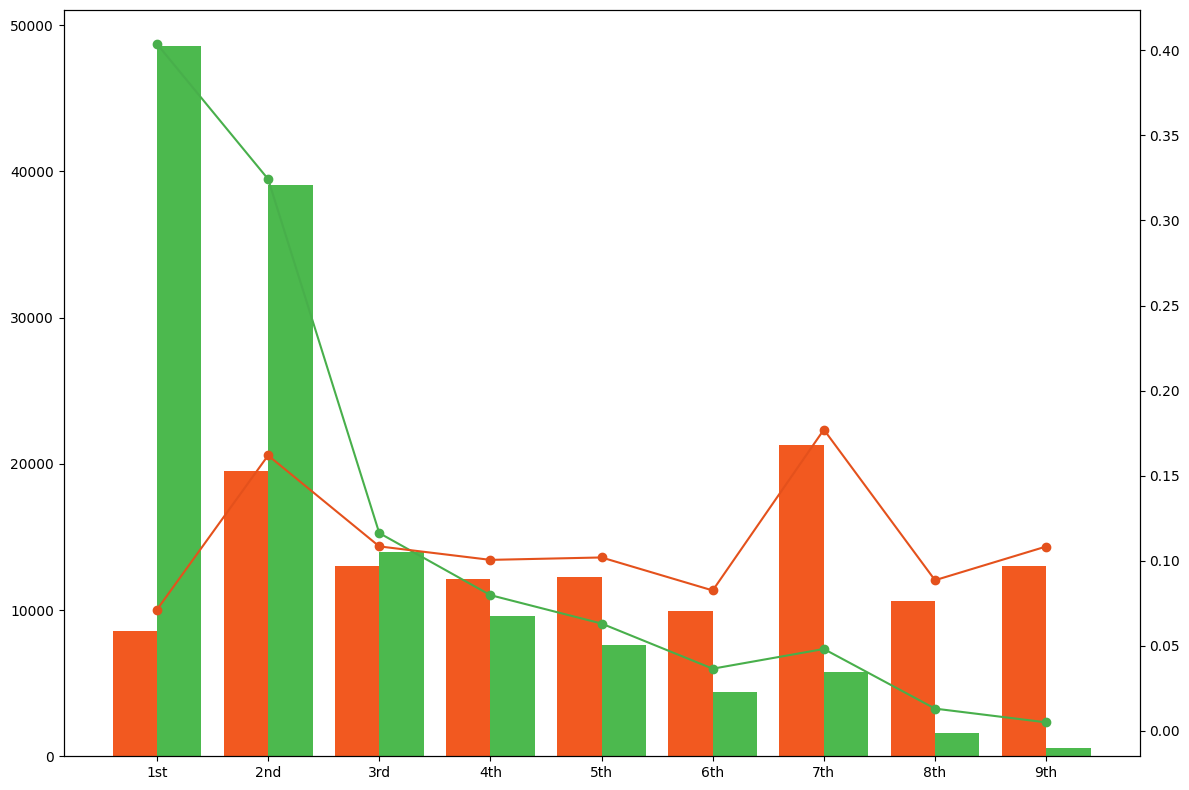

In [ ]:
fig, ax1 = plt.subplots(figsize = (12, 8))

stablity = ax1.bar(
    credit_default_stable_data["ScoreCard"],
    list(map(float, credit_default_stable_data["Count"])),
    align = "edge", width = 0.4, color = "#4CB94E", label = "stable loan")
risk = ax1.bar(
    credit_default_risky_data["ScoreCard"],
    list(map(float, credit_default_risky_data["Count"])),
    align = "edge", width = -0.4, color = "#F25920", label = "risky loan")

ax2 = ax1.twinx()
ax2.plot(
    credit_default_stable_data["ScoreCard"],
    credit_default_stable_data["Ratio"],
    marker = "o", color = "#48AF4B")
ax2.plot(
    credit_default_risky_data["ScoreCard"],
    credit_default_risky_data["Ratio"],
    marker = "o", color = "#E4511C")


fig.tight_layout()
plt.show()

In [ ]:
"""
stablity = plt.bar(
    credit_default_stable_data["ScoreCard"],
    list(map(float, credit_default_stable_data["Count"])),
    align = "edge", width = 0.4, color = "blue")
risk = plt.bar(
    credit_default_risky_data["ScoreCard"],
    list(map(float, credit_default_risky_data["Count"])),
    align = "edge", width = -0.4, color = "red")
plt.plot(
    credit_default_risky_data["ScoreCard"],
    credit_default_risky_data["Ratio"],
    marker = "o", color = "green")
"""

기준 | 등급
* 0.2 이하	판별력 낮은 모형
* 0.2 ~ 0.4	적정한 모형
* 0.4 ~ 0.5	판별력이 좋은 모형
* 0.5 이상	판별력이 아주 좋은 모형

In [ ]:
# KS통계량(Kolmogorov-Smirnov)
# 우량 집단과 불량집단의 누적 분포의 차이를 나타내는 판별 통계량

from scipy.stats import ks_2samp
ks_2samp(
    data_credit_score.loc[data_credit_score["TARGET"] == 0, "CreditScore"],
    data_credit_score.loc[data_credit_score["TARGET"] == 1, "CreditScore"] )

# 출처: https://data-newbie.tistory.com/874
# 확률값을 정렬 후 균등하게 10등분
# 전체 집단에서 이벤트 발생 수(분위수별)
# 전체 집단에서 이벤트 발생 하지 않은 수(분위수별)
# 2개의 집단의 누적 차
# 가장 차이가 많은 부분

KstestResult(statistic=0.43958197010895583, pvalue=0.0, statistic_location=536.0, statistic_sign=-1)

In [ ]:
# PSI
# 기준시점 대비 현재분포의 차이를 나타내는 지표로 모집단의 안정성 판단기준(0.05보다 낮으면 안정성 有)
# 과거시점의 Default여부 (TARGET) 변수가 제시되지 않아 구할 수 없음